#### 1.  Packages

In [1]:
import pandas as pd
import numpy as np
import scipy.stats

import sys
import joblib

from sklearn.preprocessing import StandardScaler

pd.options.mode.chained_assignment = None  # default='warn'

In [45]:
#common training code
#to import common file
sys.path.insert(1, 'common')
import fileprocessing_common as fp
import molchem_common as molchem
import dataanalysis_common as da
import score_common as score
import modelquantification_common as quantify

# when any outside python is updated, run the following to reload the new version
%load_ext autoreload
%autoreload 

CI = quantify.CI = 0.95
z_value = quantify.z_value = scipy.stats.norm.ppf((1 + CI) / 2.0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### 2.  Variables

In [15]:
RANDOMSTATE = 42

inhibitionThreshold = 90
data_path = 'ignore/data/'
image_path = "ignore\\images\\"
model_path = 'ignore/model/'

dataset_TAACF = 'TAACF'
dataset_SRI = 'SRIKinase'
dataset = 'TAACF'
suffix_MLSMR = '_M'
suffix_TAACF = '_TS'
suffix = suffix_TAACF 

filename_TAACF = 'TAACF_CB2.csv'
filename_SRI = 'SRIkinase_lib.csv'
filename_salts = 'common/salts_default.txt'
filename_merged = 'TAACF-SRKinase_merged.csv'

filename_dataset = f'{dataset}.csv'
filename_salts = 'common/salts_default.txt'
filename_deduped = f'{dataset}_Deduped.csv'
filename_descriptors = f'{dataset_TAACF}-{dataset_SRI}_2Descriptors.csv'
filename_descriptors_vtcorr = f'featuresVTCorr{suffix}.csv'
filename_descriptors_scaled = f'featuresScaled'
filename_descriptors_unscaled = f'Descriptors'
filename_scaler = f'scaler_std'
filename_traintest_base = ''
filename_x_train = f'{data_path}X_train{suffix}.csv'
filename_y_train = f'{data_path}y_train{suffix}.csv'
filename_x_test = f'{data_path}x_test{suffix}.csv'
filename_y_test = f'{data_path}y_test{suffix}.csv'
filename_model_metrics = 'model_metrics'
filename_model_featureimportance = 'model_featureimportance'
filename_model_hyperparameter = 'model_hyperparameter'
# filename_splitsminstd = f'{DATA_PATH}SplitsMinSTD{SUFFIX}'
filename_splitsminstd = f'SplitsMinSTD'
filename_img_metrics_baseline = 'baseline_metrics'
filename_img_metrics = 'model_metrics'
filename_img_metrics_topmodels = 'model_metrics_topmodels'
filename_img_auc_baseline = f'baseline_auc'
filename_img_auc = f'_auc'
filename_img_auc_topmodels = f'_auc_topmodels'
filename_img_pr_baseline = f'baseline_precisionrecall'
filename_img_pr = f'precisionrecall'
filename_img_pr_topmodels = f'precisionrecall_topmodels'
filename_img_featureimportance_top = 'model_featureimportance_top'
filename_img_hyperparameter_top = 'model_hyperparameter_top'

col_molname = 'MoleculeName'
col_smiles = 'SMILES'
col_taacfInhibition = 'TAACF-Inhibition'
col_sriInhibition = 'SRIKinase-Inhibition'
col_inhibition = 'Inhibition'
col_taacfActive = 'TAACF-Active'
col_sriActive = 'SRI-Active'
col_active = 'Activity'
col_RDKitMol = 'RDKitMol'
col_smilesStripped = 'smilesStripped'
col_strippedSalts = 'strippedSalts'
col_NonDescriptors = ["MoleculeName", "SMILES", "RDKitMol", "molStripped", "strippedSalts", "MtbH37Rv-Inhibition", "MtbH37Rv-Active", "SRIKinase-Inhibition", "SRIKinase-Active", "Activity"]
col_NonDescriptors_legacycode = ["SMILES", 'Inhibition']
func_dupekeep = 'min'
flag_datasetSRI = 'S'
flag_datasetTAACF = 'T'
flag_datasetboth = 'TS'

scaler_std = StandardScaler()

#training
models = ['crf', 'wrf', 'rfbs', 'rfu', 'rfee']
testsize1=0.4
testsize2=0.5
topFeatureCount = 10
thresholds = ['ROC Th', 'PR Th']
dfScores = pd.DataFrame()
dfMetrics = pd.DataFrame()
dfPrecisionRecall = pd.DataFrame()
dfAUC = pd.DataFrame()
dfFeatures = pd.DataFrame()

dir_AUC = 'AUC'
dir_PrecisionRecall = 'PrecisionRecall'
xy_PrecisionRecall = ['Recall', 'Precision']
xy_AUC = ['FPR', 'TPR']
footnote_models = 'CRF = Classic RF,  WRF = Weighted RF,  RFBS = RF with Balanced Subsample,  RFEE = RF with Easy Ensemble,  RFU = RF with Undersampling'
featureImportance_th = 0.90
topFeatureCount=10

#split_traintest = '80/20'

#### 3.  Import data

In [11]:
#import TAACF data, rename for intellisys and get row count
dataTAACF = pd.read_csv(f"{data_path}{filename_TAACF}")
dataTAACF = dataTAACF.rename(columns={'Molecule Name': col_molname})
dataTAACF = dataTAACF.rename(columns={'Mtb (H37Rv) Percent Inhibition (10 μg/mL): % Inhibition (%)': col_taacfInhibition})

#import SRIKinase data, rename for intellisys and get row count
dataSRI = pd.read_csv(f"{data_path}{filename_SRI}")
dataSRI = dataSRI.rename(columns={'Molecule Name': col_molname})
dataSRI = dataSRI.rename(columns={'TB SRI Kinase Phenotypic Screen SP: % Inhibition @10ug/ml (%)': col_sriInhibition})

#### 4.  Remove molecules w/missing data

In [12]:
# variables:  dataframe, deleteMissingData, printStatus, dataset name
dataTAACF, dataTAACFCount = fp.deleteMolWithMissingData(dataTAACF, True, True, dataset_TAACF)
dataSRI, dataSRICount = fp.deleteMolWithMissingData(dataSRI, True, True, dataset_SRI)

TAACF Data Info before deletion
---------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109025 entries, 0 to 109024
Data columns (total 3 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   MoleculeName      109025 non-null  object 
 1   SMILES            109025 non-null  object 
 2   TAACF-Inhibition  107080 non-null  float64
dtypes: float64(1), object(2)
memory usage: 2.5+ MB
None

TAACF Data Info after deletion
---------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 107080 entries, 0 to 109024
Data columns (total 3 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   MoleculeName      107080 non-null  object 
 1   SMILES            107080 non-null  object 
 2   TAACF-Inhibition  107080 non-null  float64
dtypes: float64(1), object(2)
memory usage: 3.3+ MB
None


SRIKinase Data Info before d

#### 5.  Remove duplicate SMILES

In [13]:
#check for dupes
dupesTAACF = pd.concat(rows for smiles, rows in dataTAACF.groupby(col_smiles) if len(rows) > 1)
dupesTAACFCount = dupesTAACF.shape[0]

dupesSRI = pd.concat(rows for smiles, rows in dataSRI.groupby(col_smiles) if len(rows) > 1)
dupesSRICount = dupesSRI.shape[0]

# variables:  dataframe, column to group by, column with inhibition values
dupesTAACFInfo, dupesTAACFUniqueMolCount = fp.dupeAnalysis(dupesTAACF, col_smiles, col_taacfInhibition, dataset_TAACF)
dupesSRIInfo, dupesSRIUniqueMolCount = fp.dupeAnalysis(dupesSRI, col_smiles, col_sriInhibition, dataset_SRI)

Duplicate count:  9595
# of unique molecuLes that are duplicated:  3203
---------------------------------------------
   Duplicate count  Molecule Count
0                3            3189
1                2              14


Duplicate count:  3128
# of unique molecuLes that are duplicated:  1254
---------------------------------------------
   Duplicate count  Molecule Count
0                2             934
1                4             300
2                3              20




In [14]:
# remove duplicates
# variables:  dataframe, column to group by, column with inhibition values, function used to determine which duplicate to keep
dataTAACF = fp.dedupeByOneColumn(dataTAACF, col_smiles, col_taacfInhibition, func_dupekeep)
dataSRI = fp.dedupeByOneColumn(dataSRI, col_smiles, col_sriInhibition, func_dupekeep)

#check duped worked by counts
if dataTAACF.shape[0] == (dataTAACFCount - (dupesTAACFCount - dupesTAACFUniqueMolCount)):
    print(f"{dataset_TAACF} Success:  df deduped.  Final row count is {dataTAACF.shape[0]}")
else:
    print("{dataset_TAACF} Error:  Final row count does not match expected deduped row count")

if dataSRI.shape[0] == (dataSRICount - (dupesSRICount - dupesSRIUniqueMolCount)):
    print(f"{dataset_SRI} Success:  df deduped.  Final row count is {dataSRI.shape[0]}")
else:
    print("{dataset_SRI} Error:  Final row count does not match expected deduped row count")


dataTAACF.to_csv(f"{data_path}{dataset_TAACF}_Deduped.csv", index=False)
dataSRI.to_csv(f"{data_path}{dataset_SRI}_Deduped.csv", index=False)

TAACF Success:  df deduped.  Final row count is 100688
SRIKinase Success:  df deduped.  Final row count is 23797


#### 6.  Get Molecule from SMILES

In [15]:
# add RDKit mol column
if col_RDKitMol not in dataTAACF.columns:
    dataTAACF.insert(loc=2, column=col_RDKitMol, value=None)
if col_RDKitMol not in dataSRI.columns:
    dataSRI.insert(loc=2, column=col_RDKitMol, value=None)

# verify SMILES is valid
dataTAACF_validSMILES = molchem.rdkitMolFromSmiles(dataTAACF, col_smiles, col_RDKitMol)
dataSRI_validSMILES = molchem.rdkitMolFromSmiles(dataSRI, col_smiles, col_RDKitMol)

if dataTAACF.shape[0] == dataTAACF_validSMILES.shape[0]:
    print(f"{dataset_TAACF} Status:  all smiles are valid")    
else:
    print(f"{dataset_TAACF} Status:  invalid smiles found and deleted")
dataTAACF = dataTAACF_validSMILES

if dataSRI.shape[0] == dataSRI_validSMILES.shape[0]:
    print(f"{dataset_SRI} Status:  all smiles are valid")    
else:
    print(f"{dataset_SRI} Status:  invalid smiles found and deleted")
dataSRI = dataSRI_validSMILES

TAACF Status:  all smiles are valid
SRIKinase Status:  all smiles are valid


#### 7.  Strip Salts from molecules

In [16]:
#add salt stripped columns
if col_smilesStripped not in dataTAACF.columns:
    dataTAACF.insert(loc=3, column=col_smilesStripped, value=None)
if col_strippedSalts not in dataTAACF.columns:
    dataTAACF.insert(loc=4, column=col_strippedSalts, value=None)
if col_smilesStripped not in dataSRI.columns:
    dataSRI.insert(loc=3, column=col_smilesStripped, value=None)
if col_strippedSalts not in dataSRI.columns:
    dataSRI.insert(loc=4, column=col_strippedSalts, value=None)

#strip salts 
molchem.rdkitStripSaltFromMol(dataTAACF, col_RDKitMol, col_smilesStripped, col_strippedSalts, False, True, filename_salts)
molchem.rdkitStripSaltFromMol(dataSRI, col_RDKitMol, col_smilesStripped, col_strippedSalts, False, True, filename_salts)

dataTAACF.to_csv(f"{data_path}{dataset_TAACF}_RdKitMol.csv", index=False)
dataSRI.to_csv(f"{data_path}{dataset_SRI}_RdKitMol.csv", index=False)

In [17]:
#get mol that were stripped
dataTAACF.loc[~dataTAACF[col_strippedSalts].isnull()]

MoleculeName                                  SMILES  \
96420      6147273  OC(=O)\C=C/C(O)=O.CN(C)CC1=CC=C(O)C=C1   

                                                RDKitMol     smilesStripped  \
96420  <rdkit.Chem.rdchem.Mol object at 0x000001D0A0F...  CN(C)Cc1ccc(O)cc1   

                                           strippedSalts  TAACF-Inhibition  
96420  <generator object rdkitStripSaltFromMol.<local...               0.0

In [18]:
dataSRI.loc[~dataSRI[col_strippedSalts].isnull()]

Empty DataFrame
Columns: [MoleculeName, SMILES, RDKitMol, smilesStripped, strippedSalts, SRIKinase-Inhibition]
Index: []

#### 8.  Set Active flag for individual datasets

In [19]:
# add active column
dataTAACF[col_taacfActive] = (dataTAACF[col_taacfInhibition] >= inhibitionThreshold).astype(int)
dataSRI[col_sriActive] = (dataSRI[col_sriInhibition] >= inhibitionThreshold).astype(int)

dataTAACF.sort_values(by=['MoleculeName'], ignore_index=True)
dataSRI.sort_values(by=['MoleculeName'], ignore_index=True)

#print df to .csv 
dataTAACF.to_csv(f"{data_path}{dataset_TAACF}_Final.csv", index=False)
dataSRI.to_csv(f"{data_path}{dataset_SRI}_Final.csv", index=False)

#### 9.  Merge files

In [22]:
#get processed datasets if you would like to continue from this part of the notebook on
GetTAACFnSRIKinase = False
if GetTAACFnSRIKinase:
    dataTAACF = pd.read_csv(f"{data_path}{dataset_TAACF}_Final.csv", dtype={'strippedSalts': object})
    dataSRI = pd.read_csv(f"{data_path}{dataset_SRI}_Final.csv", dtype={'strippedSalts': object})

In [25]:
# merge datasets
params = {'df1': dataTAACF, 
        'df2': dataSRI, 
        'col_MergeOn': col_smilesStripped, 
        'col_df1Inhibition': col_taacfInhibition, 
        'col_df2Inhibition': col_sriInhibition,
        'col_df1Active': col_taacfActive,
        'col_df2Active': col_sriActive,
        'flag_df1': flag_datasetTAACF,
        'flag_df2': flag_datasetSRI,
        'flag_both': flag_datasetboth}

data = fp.mergeDatasets(**params)
data.to_csv(f"{data_path}{filename_merged}", index=False)


Molecules in merged files:
------------------------------------------------------------
Molecules on both files:  391
Molecules just in TAACF not in SRIKinase:  100297
Molecules just in SRIKinase not in TAAACF:  23406
Molecules in merged df:  124094
SUCCESS:  Merged file has all rows

Actives in merged files:
------------------------------------------------------------
Merged df actives:  3006
Merged df inactives:  121088
SUCCESS:  Merged file Activity column added


#### 10.  Extract 2D descriptors

In [26]:
# File from prior step was uploaded in MOE and 2D Descriptors retrieved
data = pd.read_csv(f"{data_path}{filename_descriptors}", dtype={'strippedSalts': object})

#extract only descriptors, and save the file for future scoring
dfDescriptors = da.get_Descriptors(data, col_NonDescriptors)
dfDescriptors.to_csv(f"{data_path}Descriptors{suffix}.csv")

C:\Users\frogi\AppData\Local\Temp\ipykernel_32824\3910214698.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(f"{data_path}{filename_descriptors}", dtype={'strippedSalts': object})


#### 11.  Extract mol info and save for later use

In [27]:
#get label and save, used later in training and scoring notebooks
data_y = data[col_active]
data_y.to_csv(f"{data_path}y{suffix}.csv")

#get just molecule information, no descriptors
data_Molecules = data.loc[:, data.columns.isin(col_NonDescriptors)].copy()

#add inhibition column and set values
data_Molecules[col_inhibition] = 0

# if molecule has inhibition only in SRIKinase dataset, then grab that inhibition value
data_Molecules.loc[(data_Molecules['Activity'] == 1) & ((data_Molecules['SRIKinase-Active'] == 1) & (data_Molecules['MtbH37Rv-Active'] == 0)), 'Inhibition'] = data_Molecules['SRIKinase-Inhibition']

# if molecule has inhibition only in TAACF dataset, then grab that inhibition value
data_Molecules.loc[(data_Molecules['Activity'] == 1) & ((data_Molecules['SRIKinase-Active'] == 0) & (data_Molecules['MtbH37Rv-Active'] == 1)), 'Inhibition'] = data_Molecules['MtbH37Rv-Inhibition']

# if molecule has inhibition in both SRIKinase & TAACF datasets, then grab the lowest inhibition value
data_Molecules.loc[(data_Molecules['Activity'] == 1) & ((data_Molecules['SRIKinase-Active'] == 1) & (data_Molecules['MtbH37Rv-Active'] == 1)), 'Inhibition'] = data_Molecules[['SRIKinase-Inhibition', 'MtbH37Rv-Inhibition']].min(axis=1)

#save molecule info, used later in dimension analaysis, training and scoring
data_Molecules.to_csv(f"{data_path}Molecules{suffix}.csv")

#### 12.  Outliers

Features with outliers: 182
Molecules affected: 215131


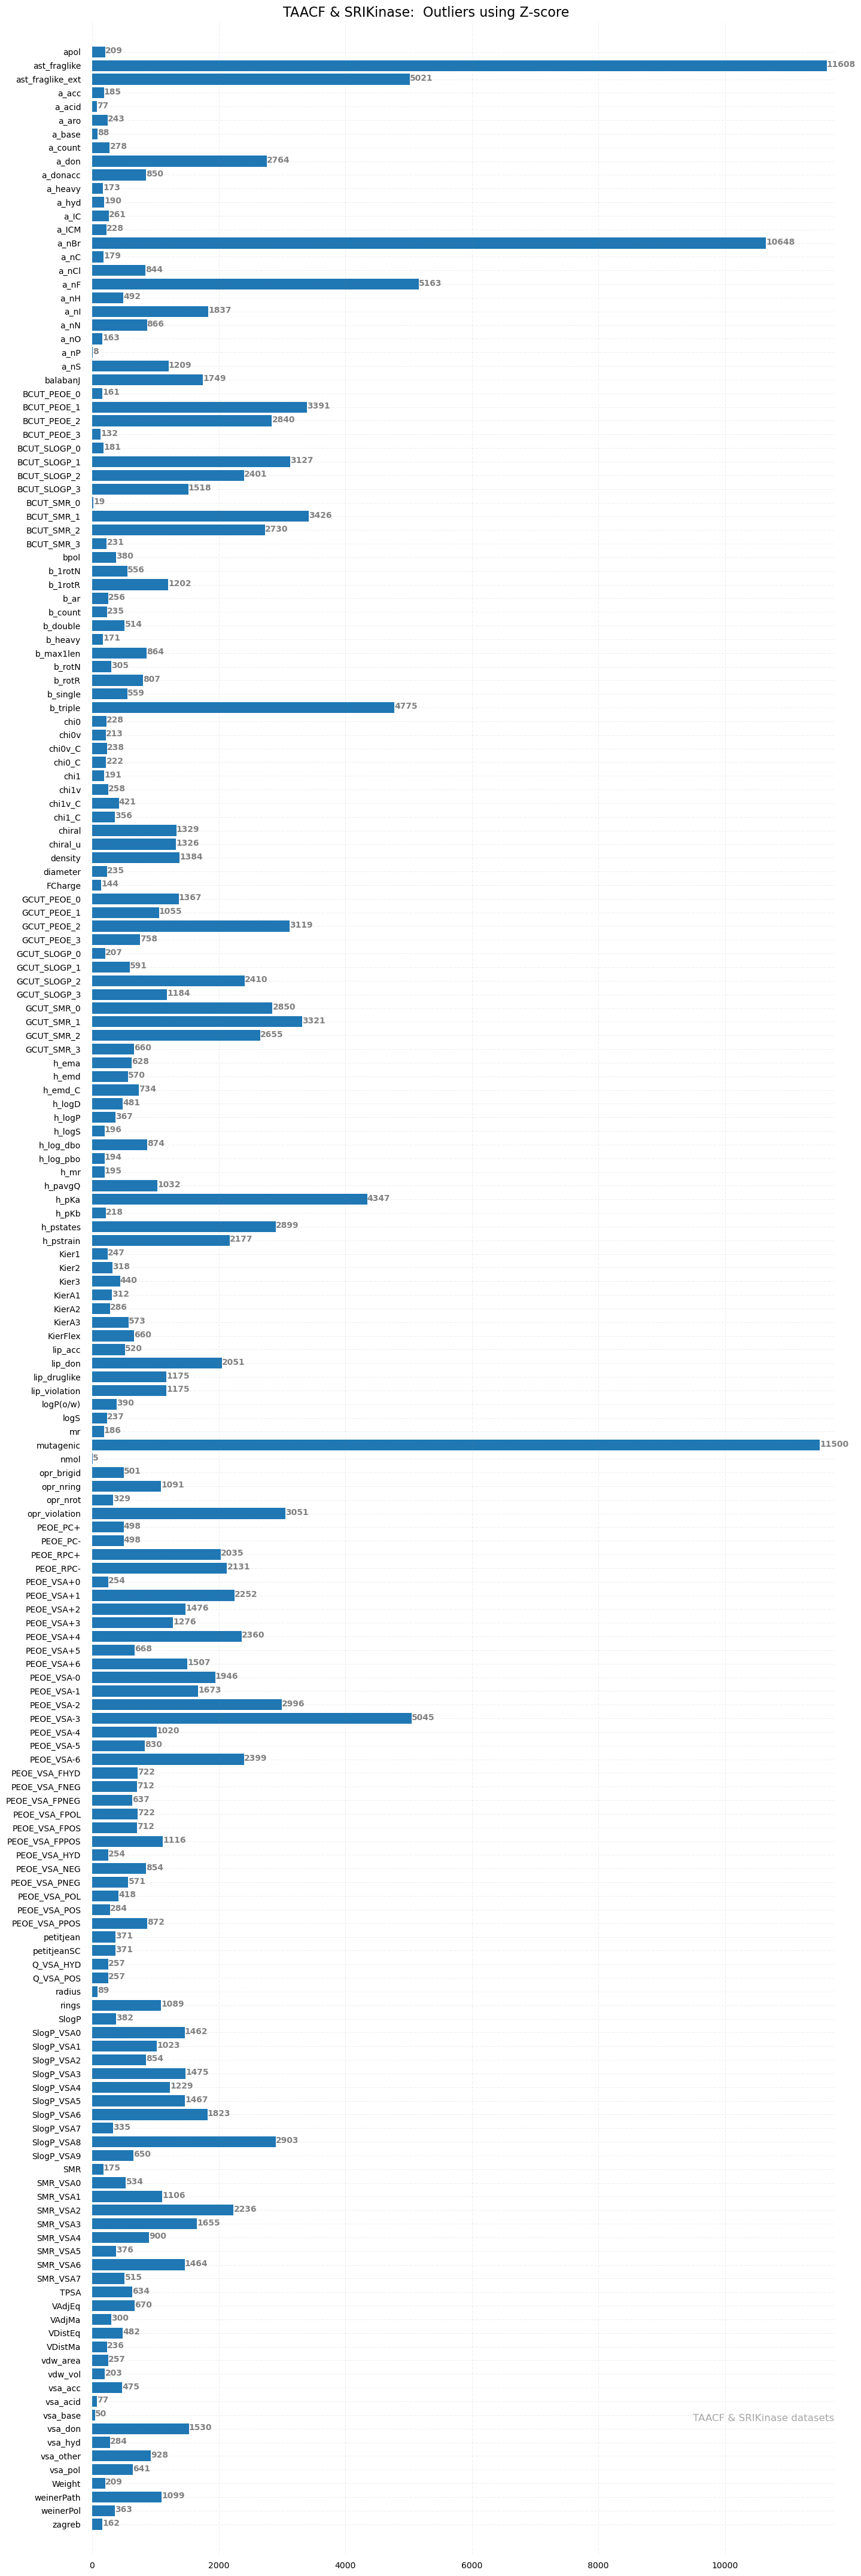

In [31]:
da.get_Outliers(dfDescriptors, 3, True, 'TAACF & SRIKinase')

#### 13.  Feature Distribution

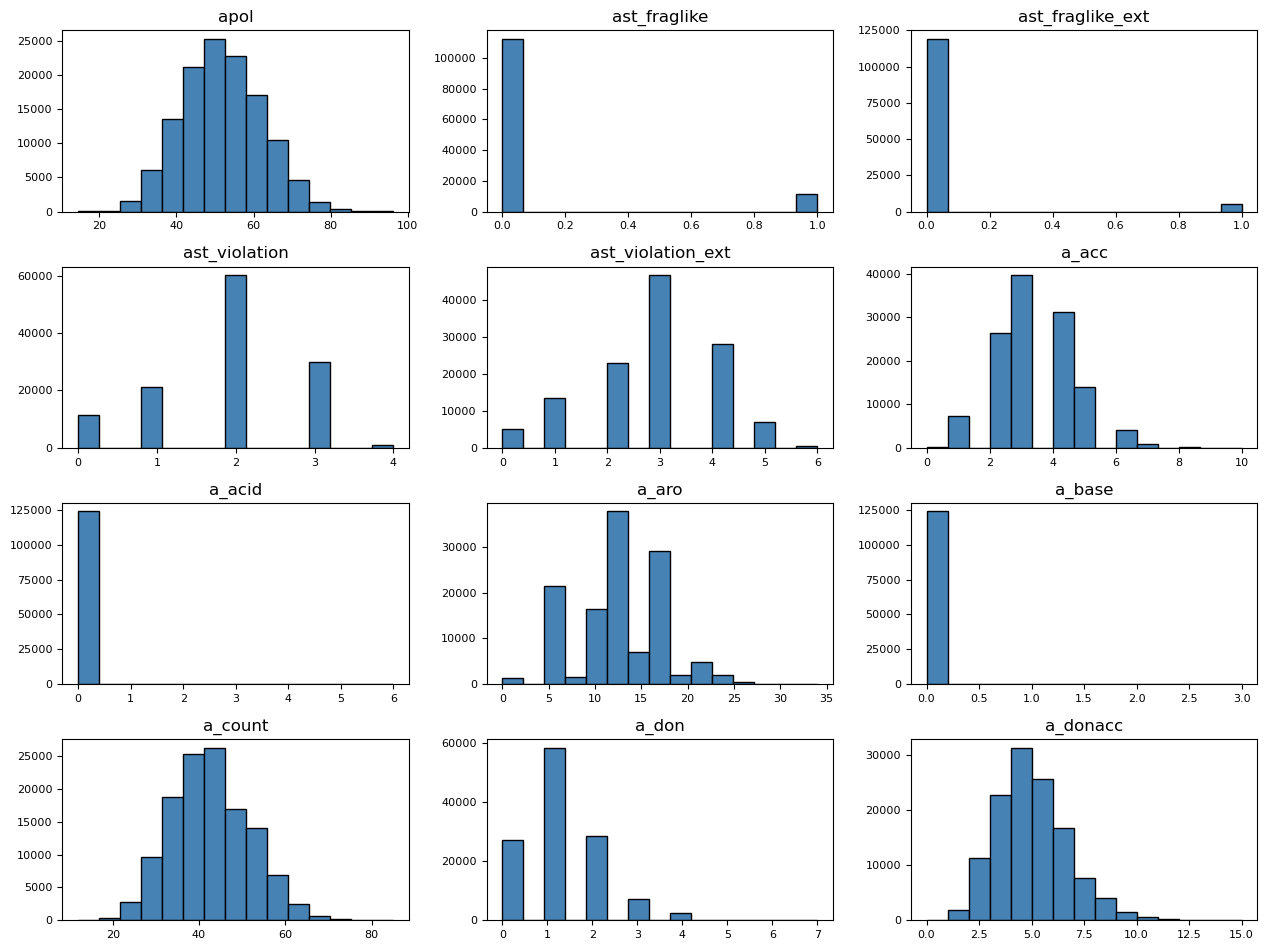

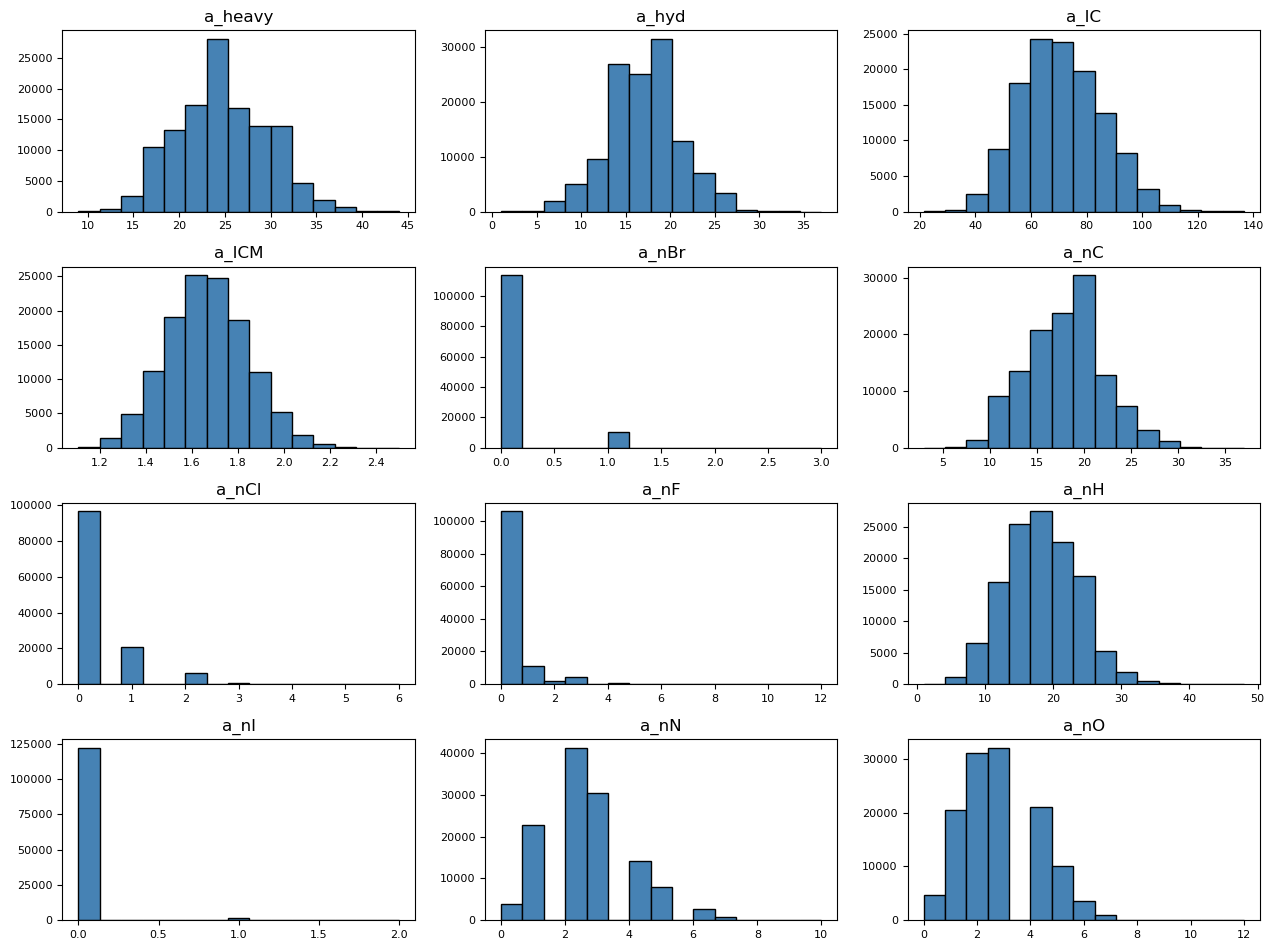

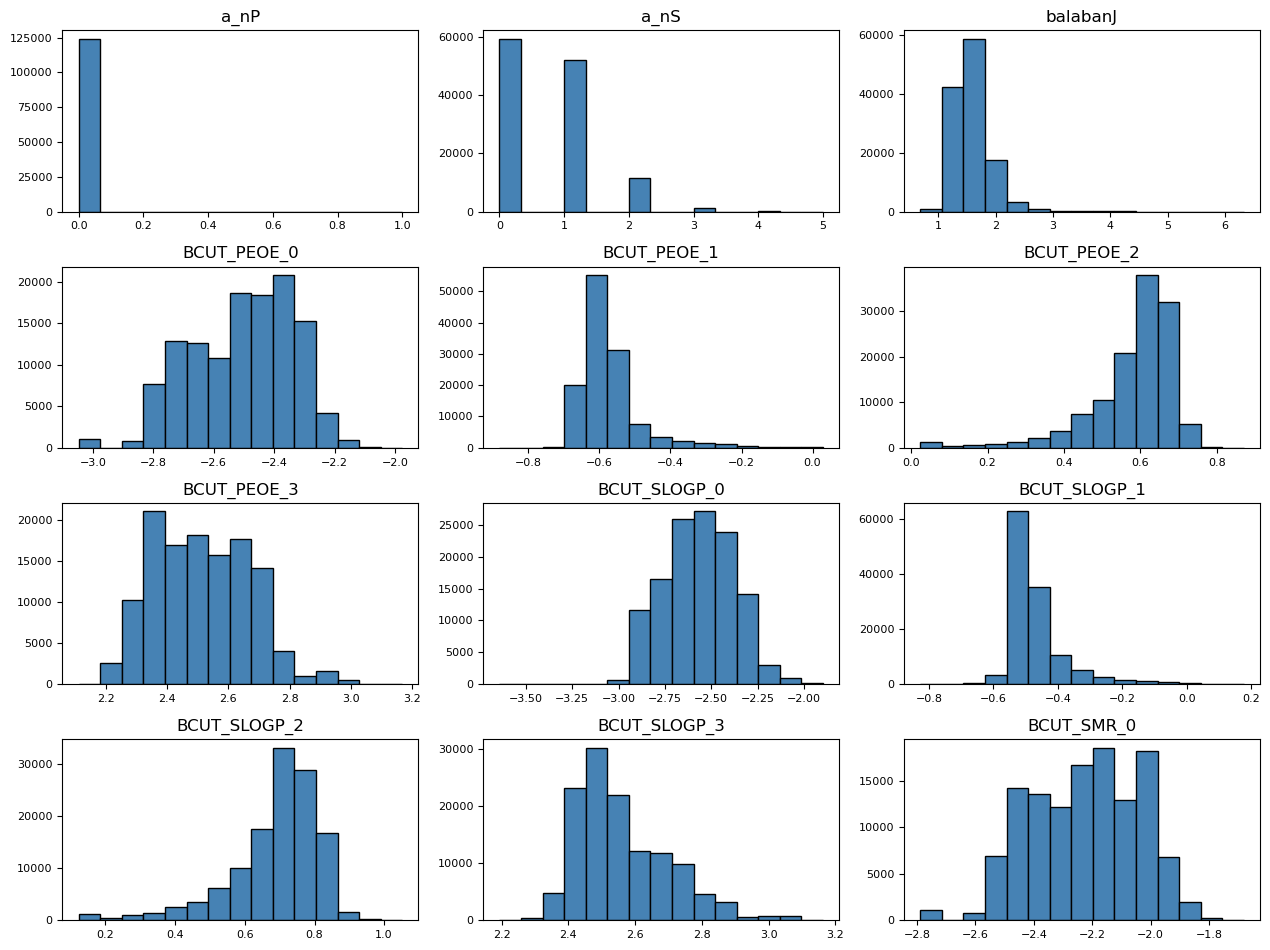

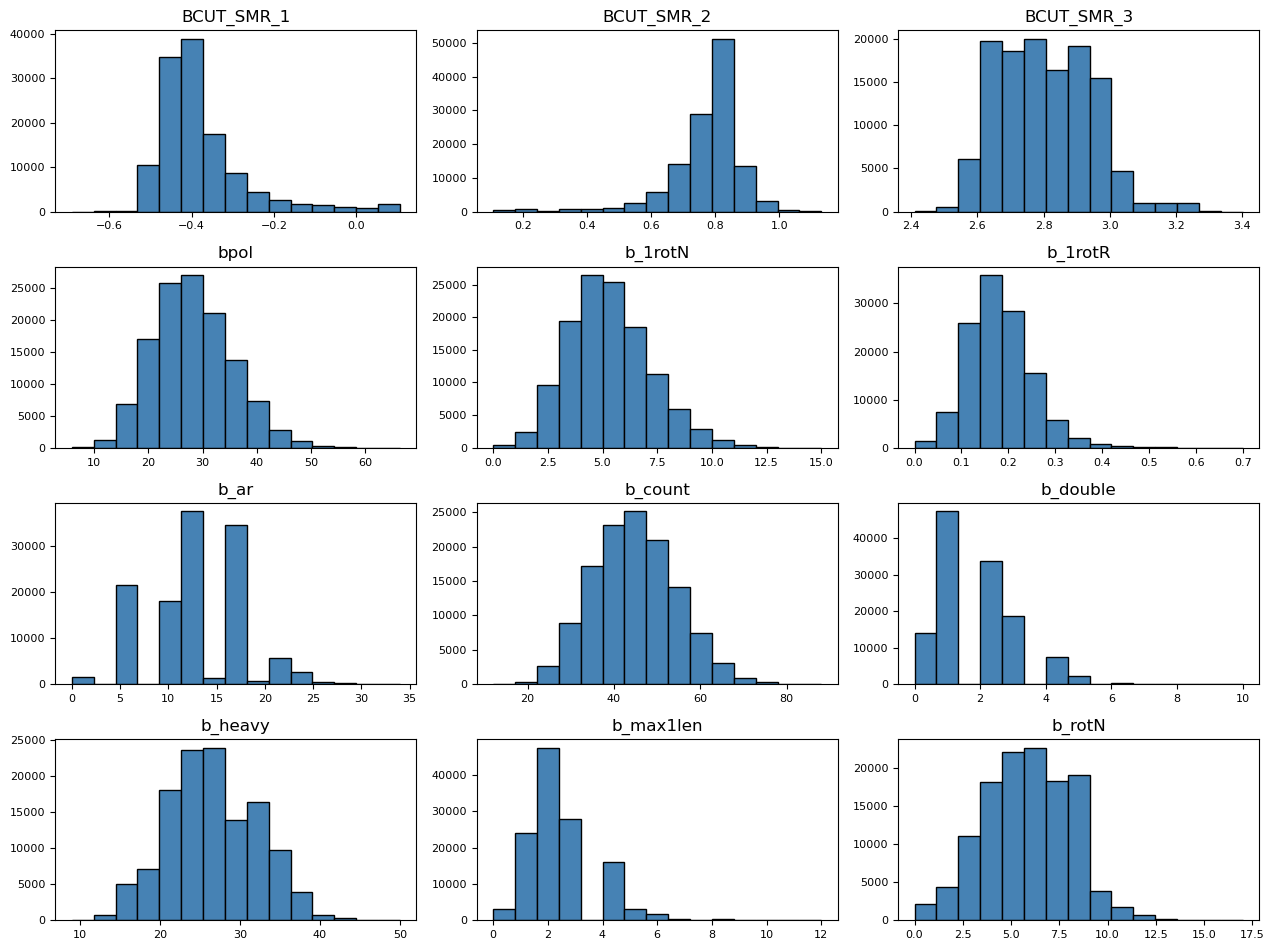

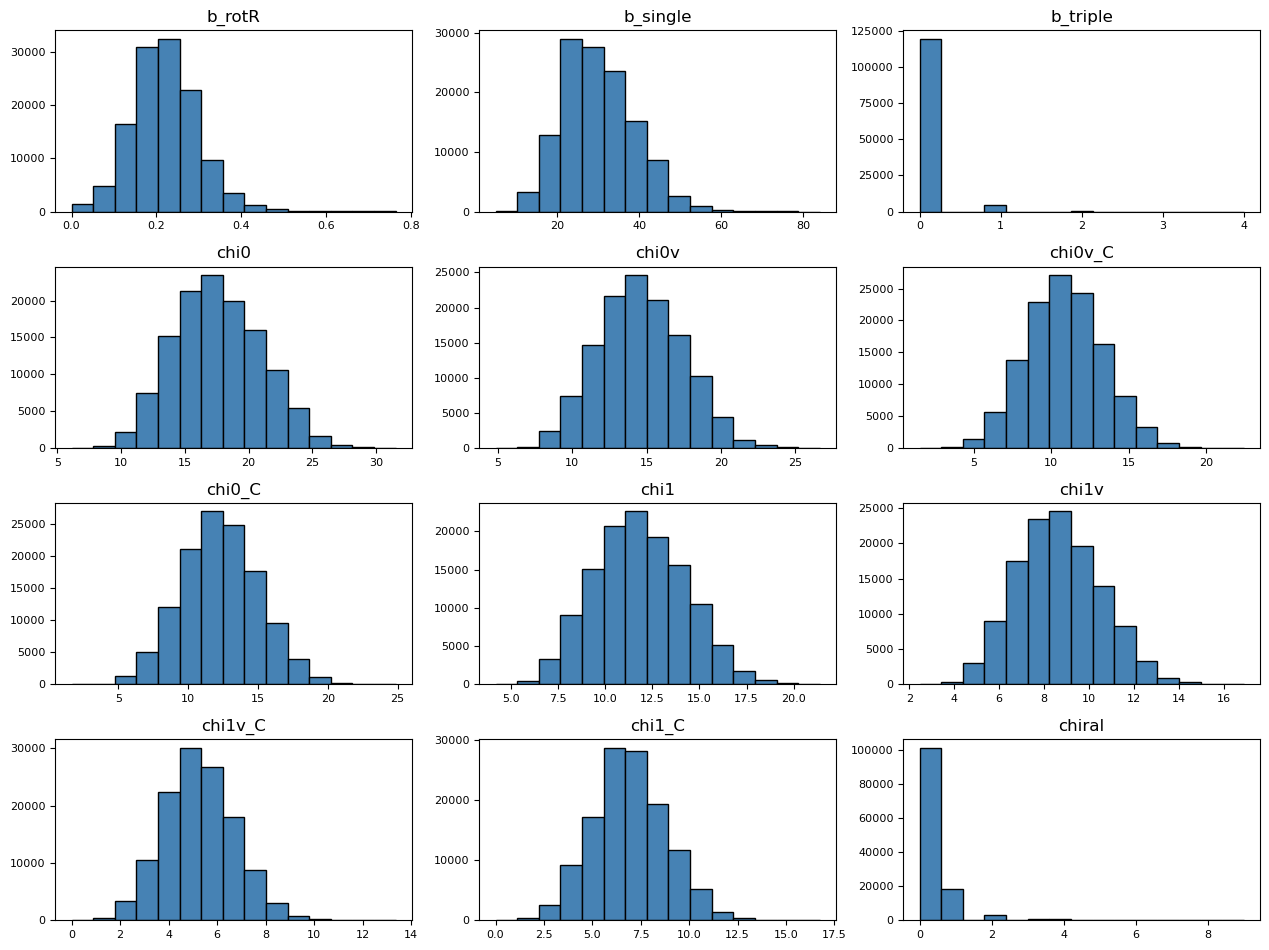

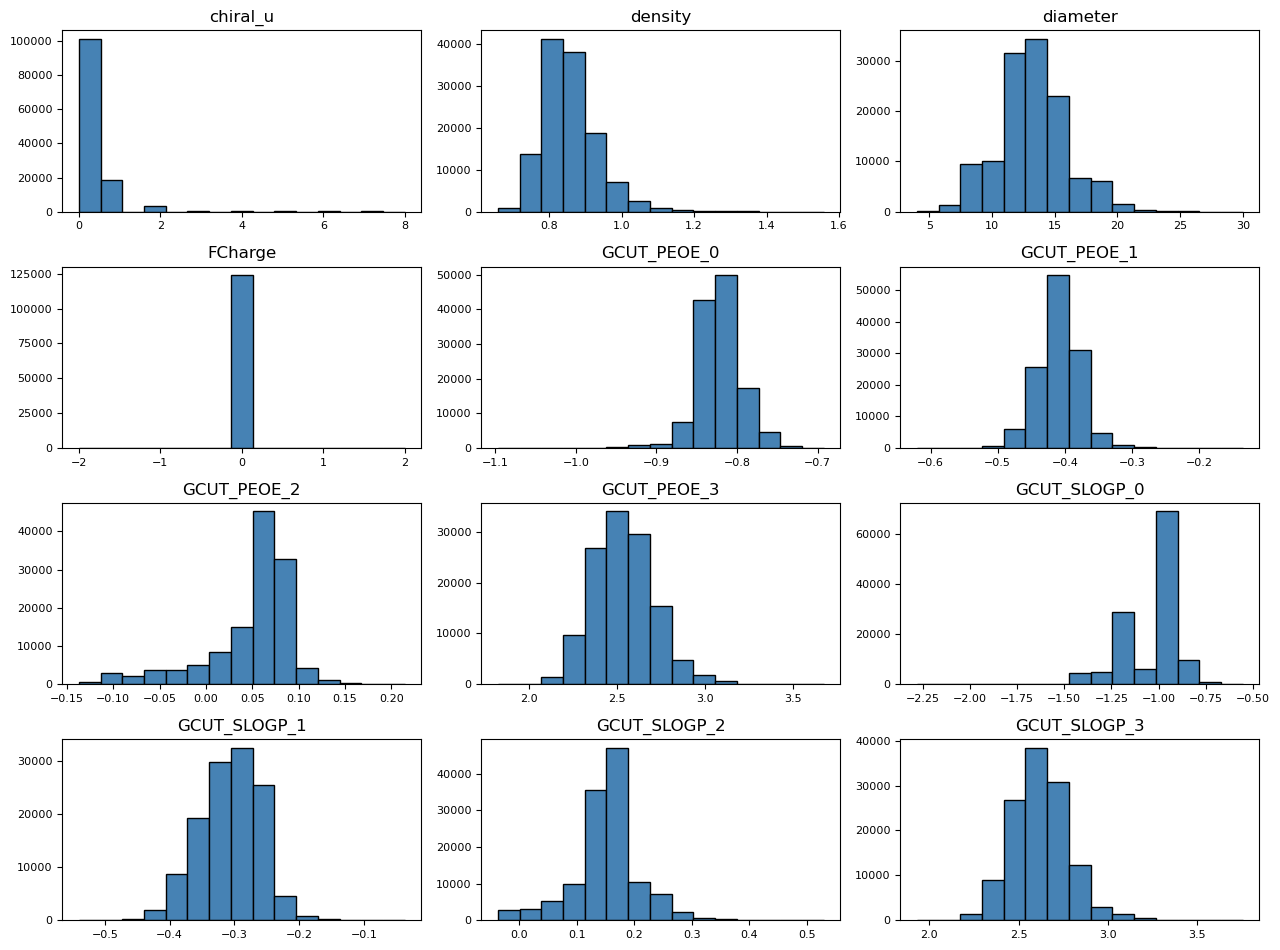

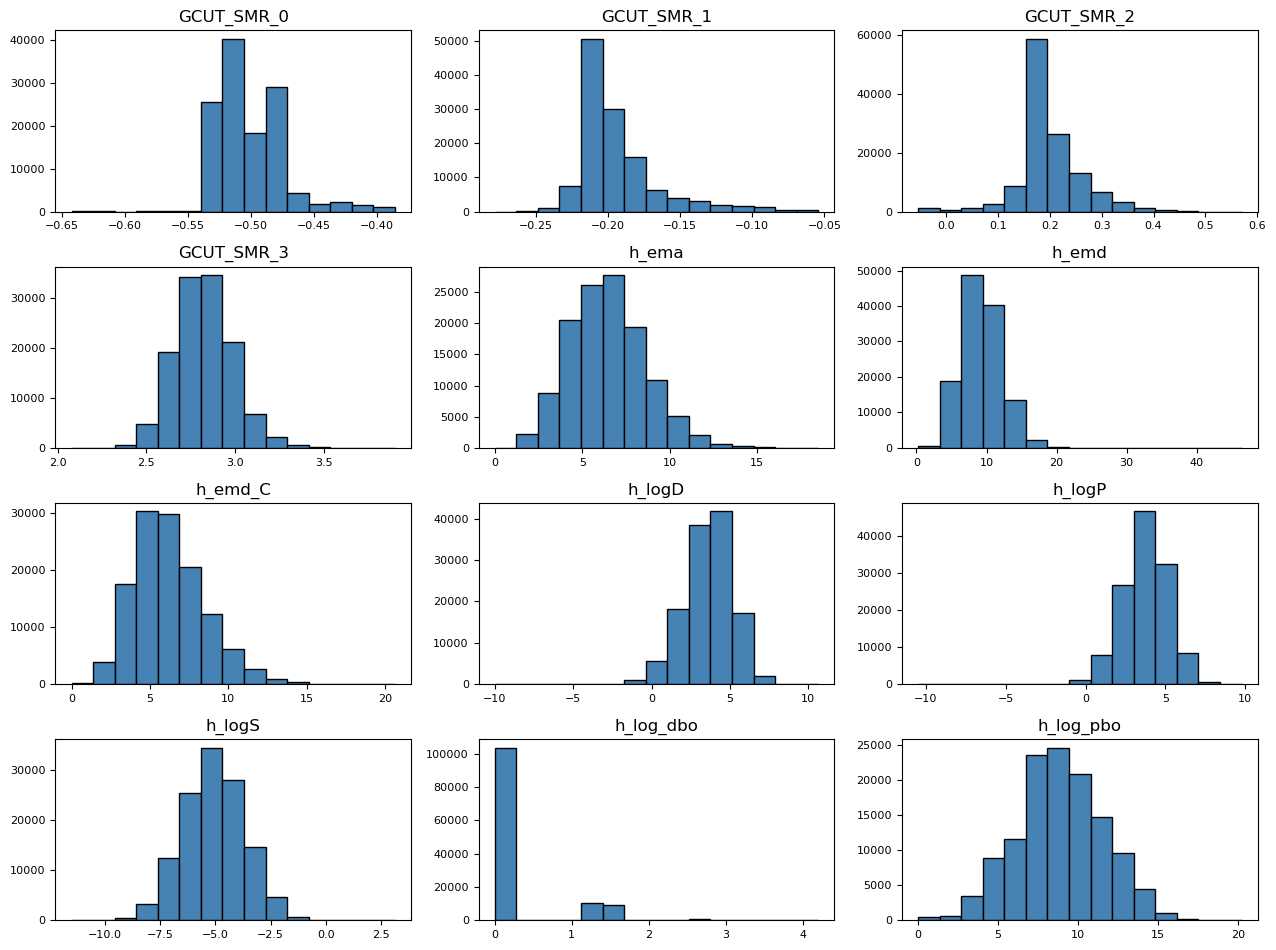

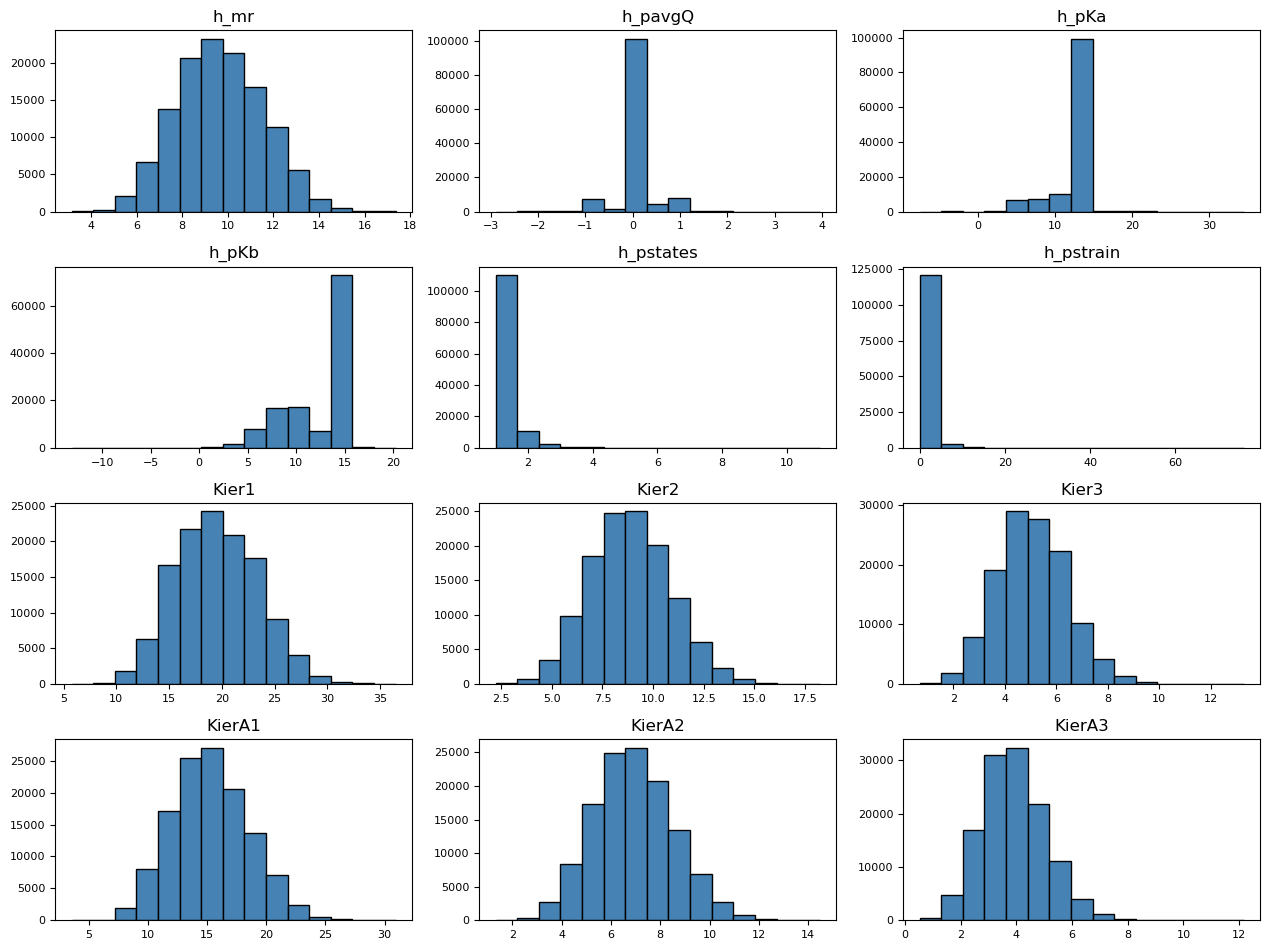

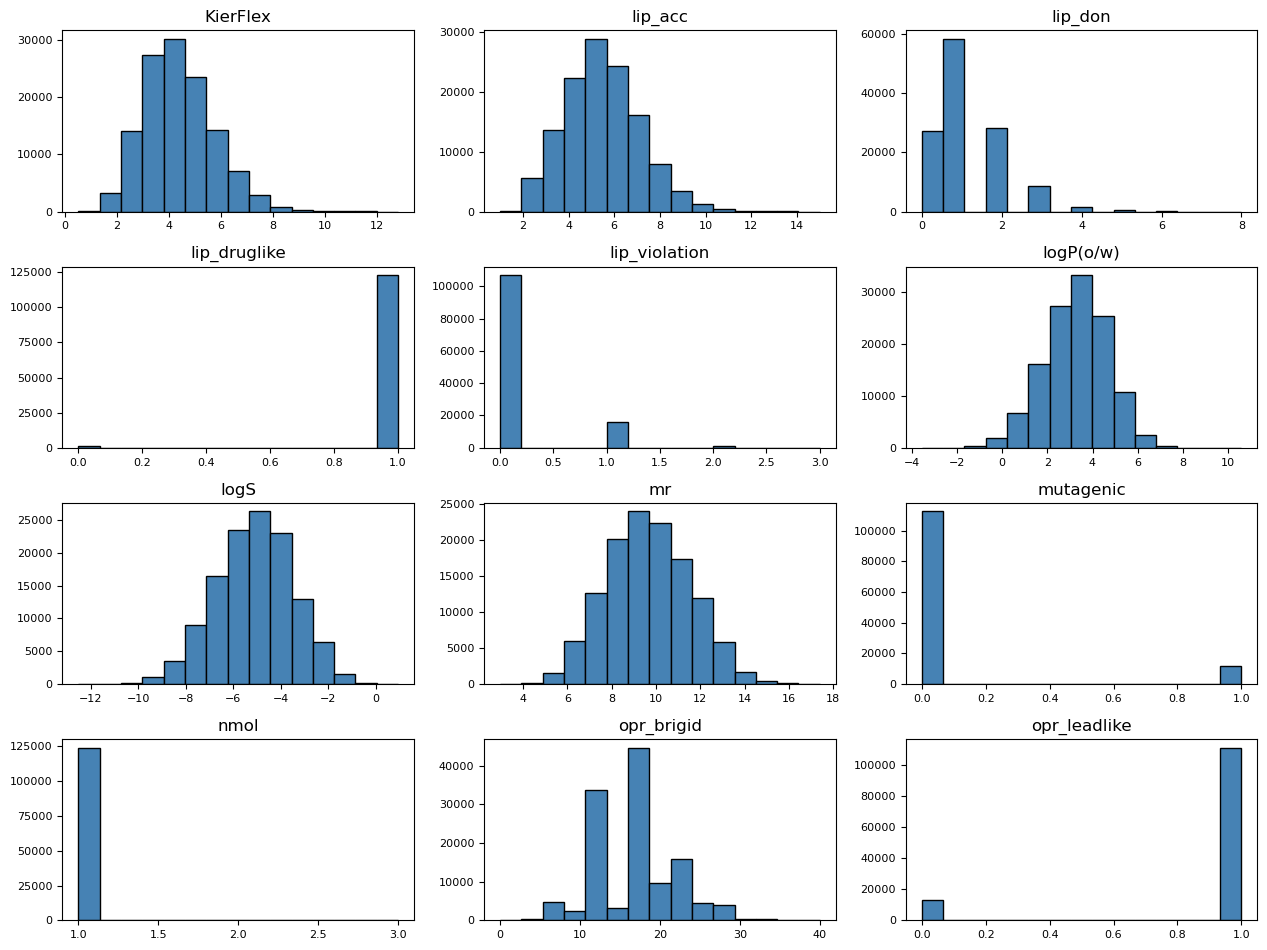

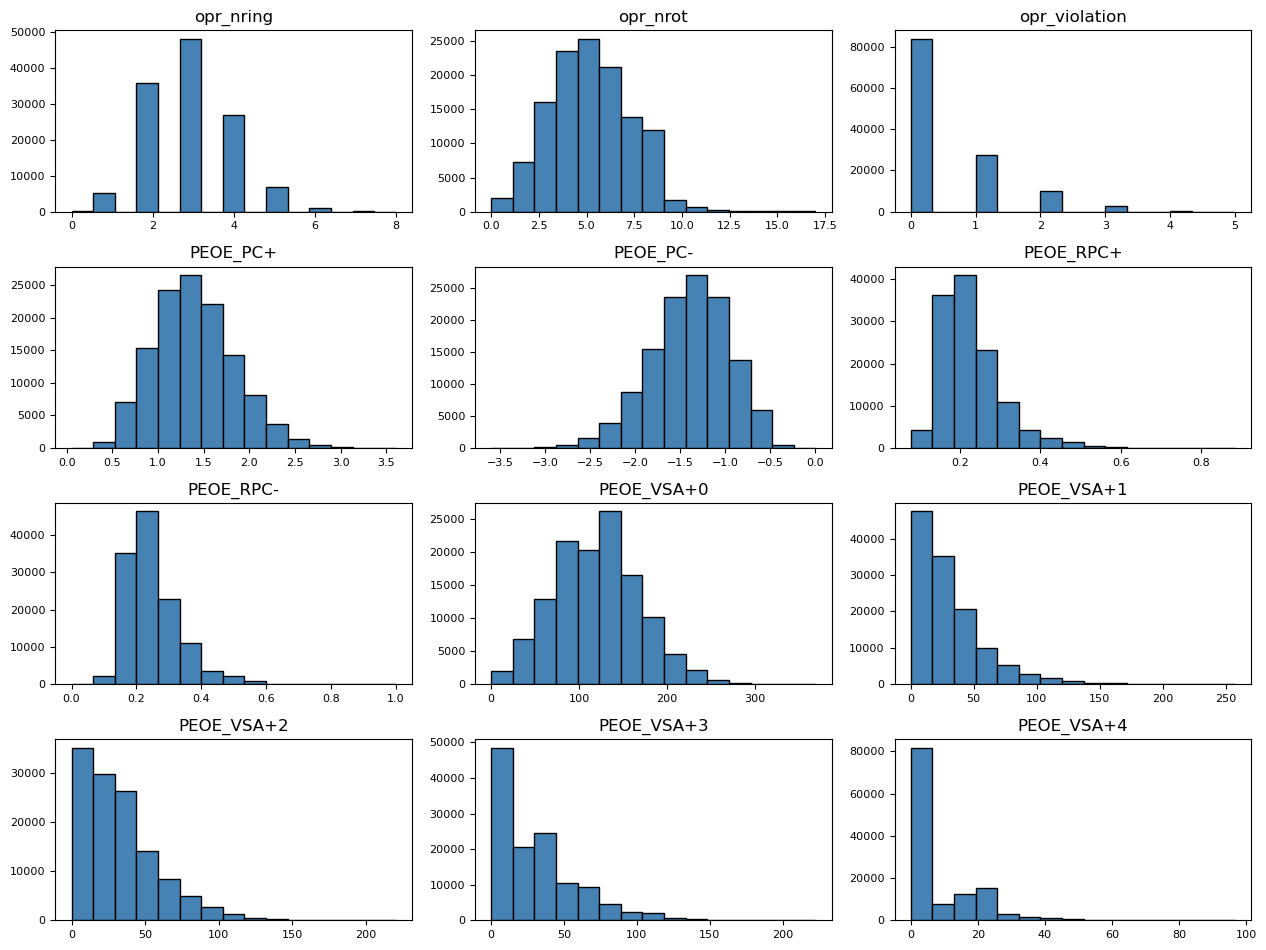

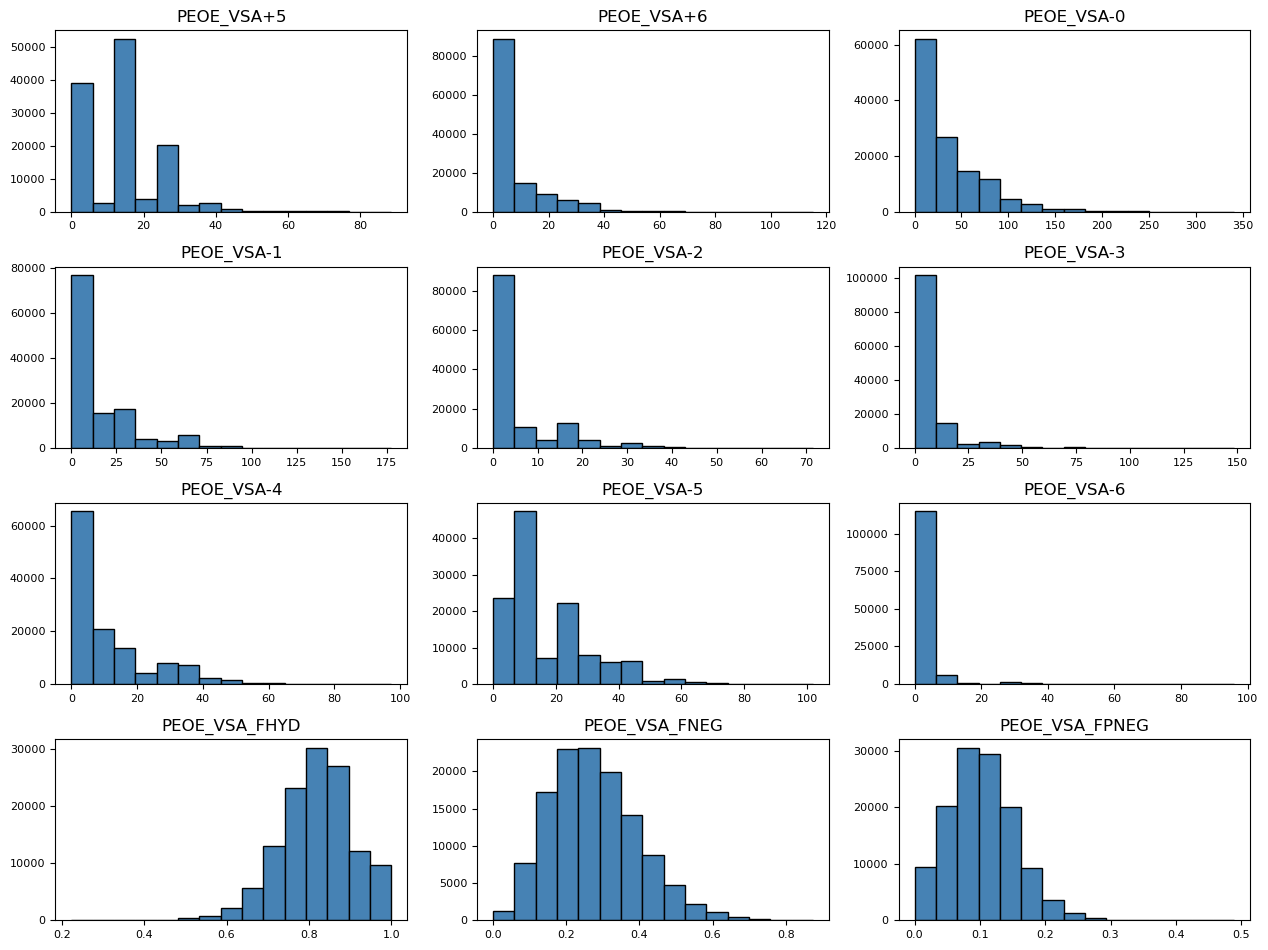

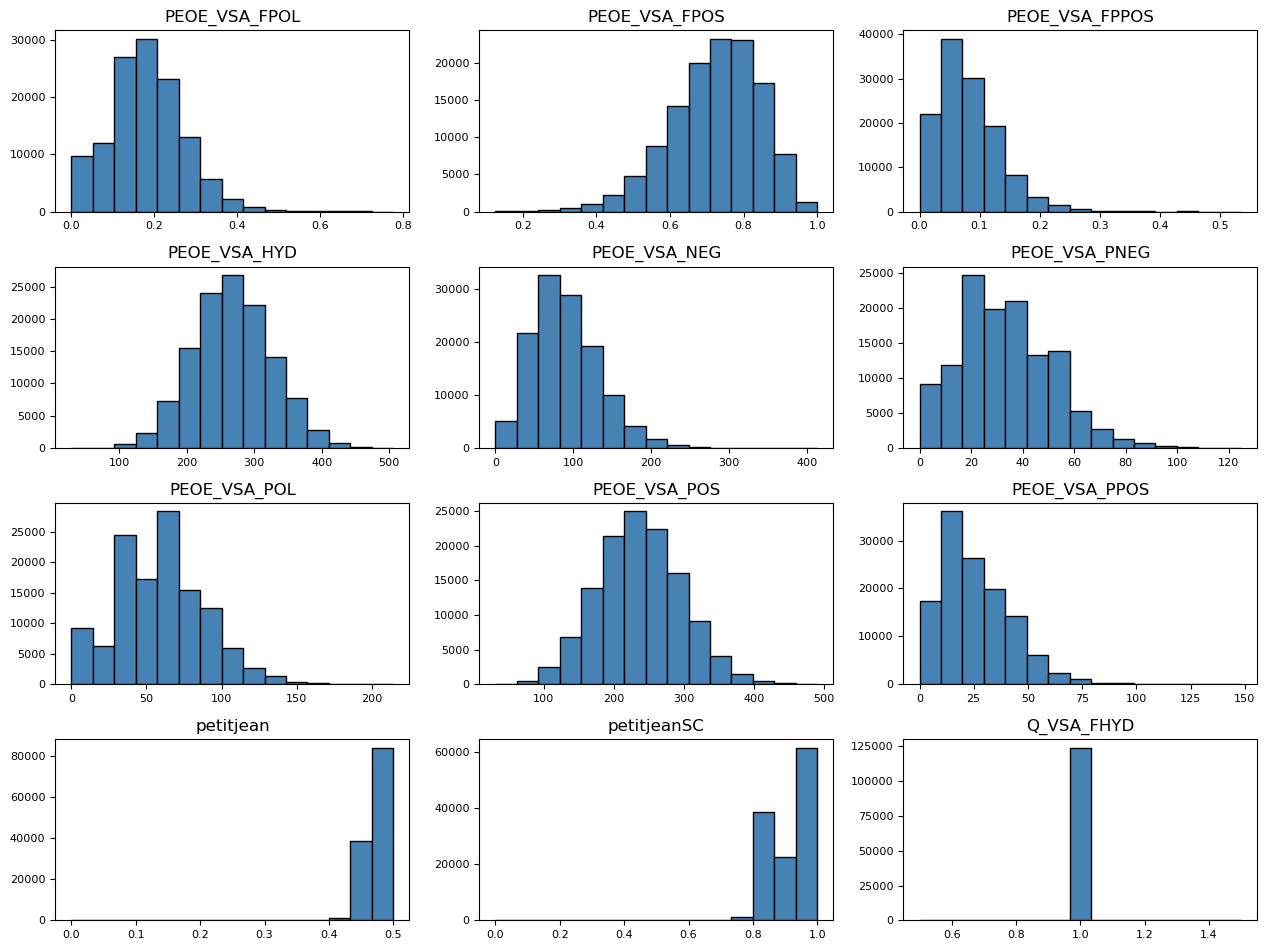

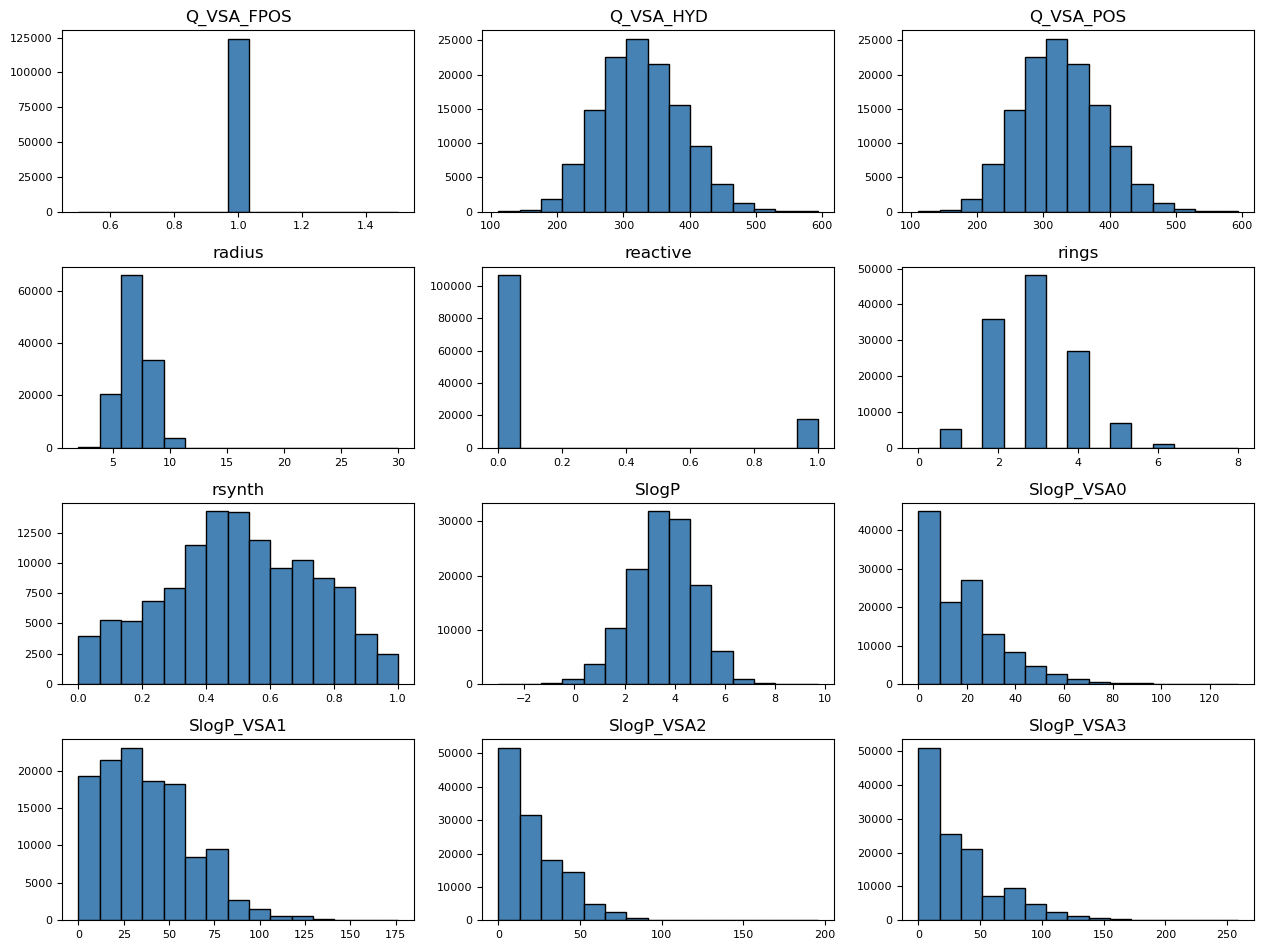

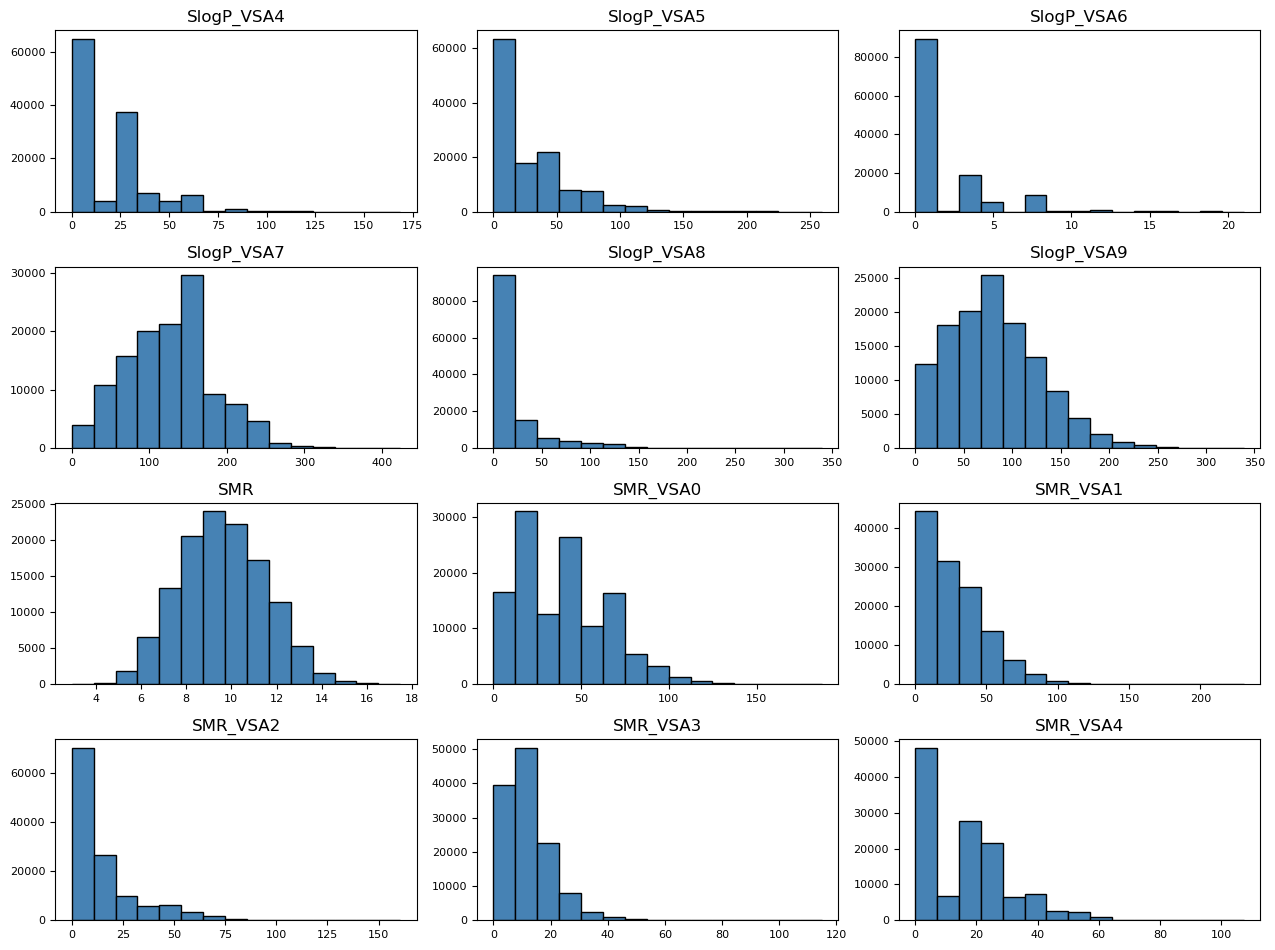

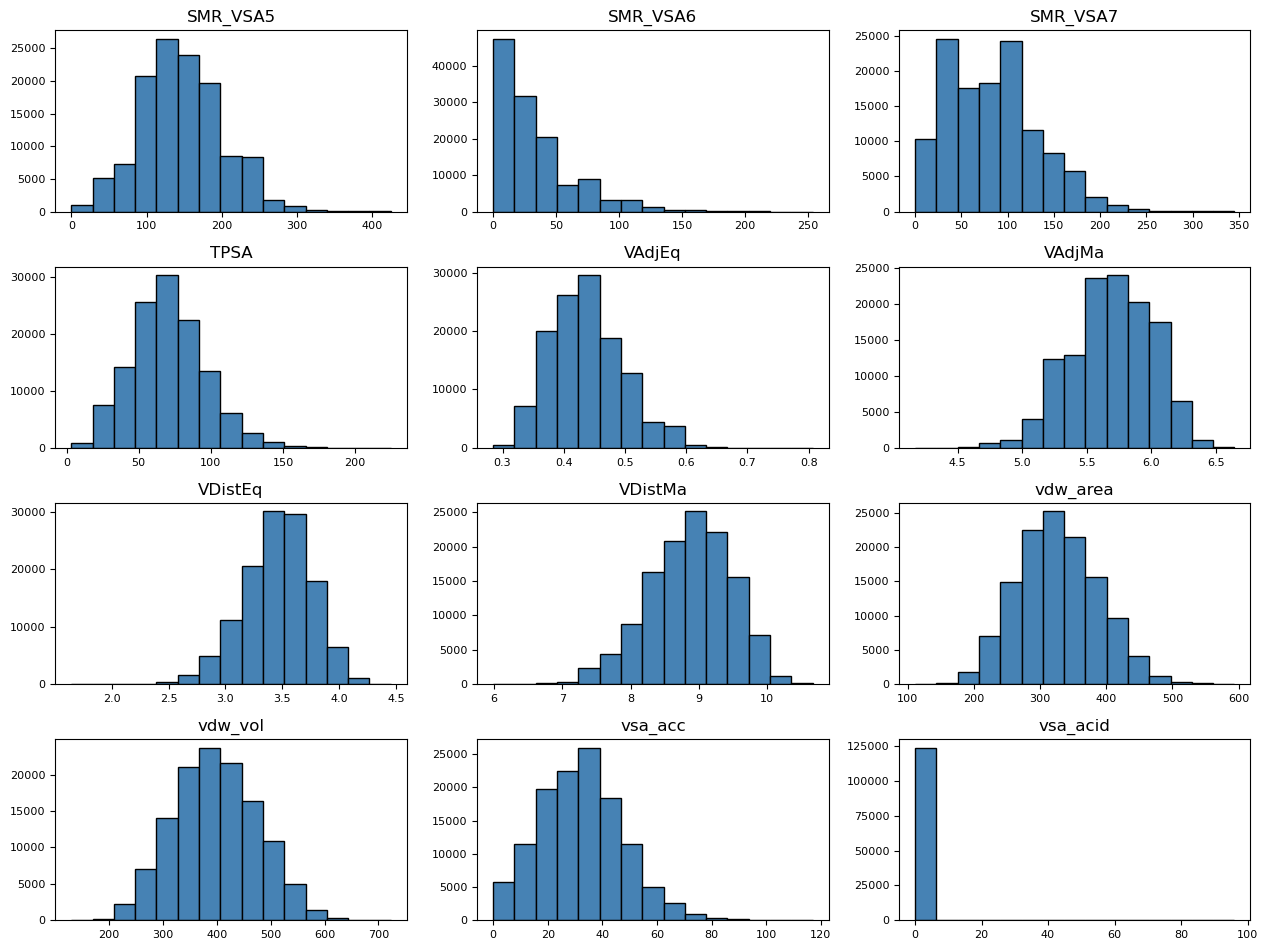

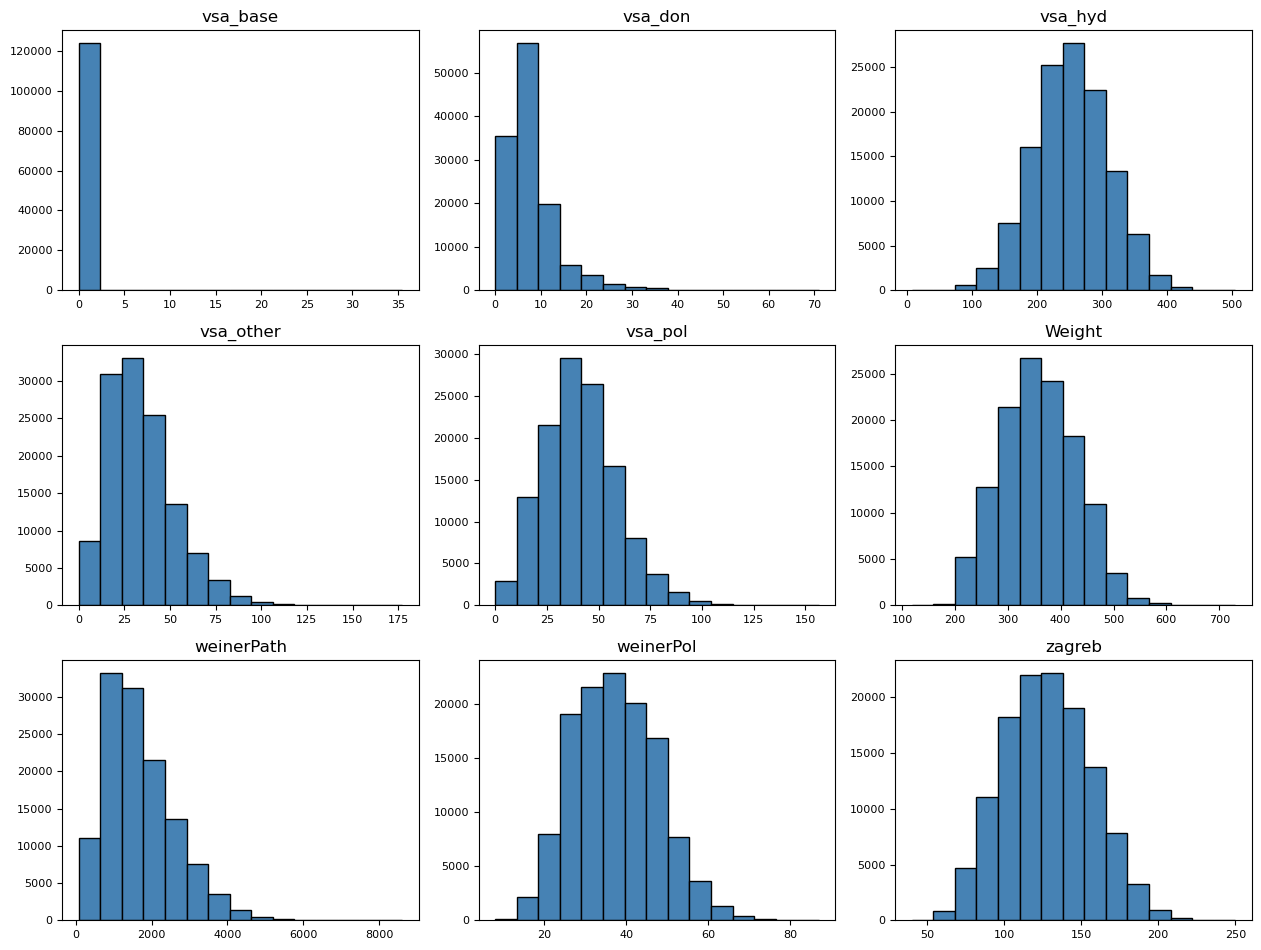

In [34]:
da.plot_FeatureDistribution(dfDescriptors)

#### 14.  Feature Selection

In [28]:
featuresCount = dfDescriptors.shape[1]

#Variance threshold applied to unscaled data 
#---------------------------------------------------------------------------------------
#drop features with a variance threshold of 0.2
vtFeatures, vtDroppedFeatures = da.apply_VarianceThreshold(dfDescriptors, 0.2, True, 'Variance Threshold')

#Drop features that are correlated 
#---------------------------------------------------------------------------------------
#drop features that are correlated
corrVTFeatures, corrVTDroppedFeatures = da.apply_Correlation(vtFeatures, 0.9, True, 'Correlated')
corrVTFeatures.to_csv(f'{data_path}{filename_descriptors_vtcorr}')


Variance Threshold Feature count
------------------------------------------------
Original count: 189
Count after VT applied: 124
Droped features:  65
['ast_fraglike', 'ast_fraglike_ext', 'a_acid', 'a_base', 'a_ICM', 'a_nBr', 'a_nI', 'a_nP', 'balabanJ', 'BCUT_PEOE_0', 'BCUT_PEOE_1', 'BCUT_PEOE_2', 'BCUT_PEOE_3', 'BCUT_SLOGP_0', 'BCUT_SLOGP_1', 'BCUT_SLOGP_2', 'BCUT_SLOGP_3', 'BCUT_SMR_0', 'BCUT_SMR_1', 'BCUT_SMR_2', 'BCUT_SMR_3', 'b_1rotR', 'b_rotR', 'b_triple', 'density', 'FCharge', 'GCUT_PEOE_0', 'GCUT_PEOE_1', 'GCUT_PEOE_2', 'GCUT_PEOE_3', 'GCUT_SLOGP_0', 'GCUT_SLOGP_1', 'GCUT_SLOGP_2', 'GCUT_SLOGP_3', 'GCUT_SMR_0', 'GCUT_SMR_1', 'GCUT_SMR_2', 'GCUT_SMR_3', 'h_pavgQ', 'h_pstates', 'lip_druglike', 'lip_violation', 'mutagenic', 'nmol', 'opr_leadlike', 'PEOE_PC+', 'PEOE_PC-', 'PEOE_RPC+', 'PEOE_RPC-', 'PEOE_VSA_FHYD', 'PEOE_VSA_FNEG', 'PEOE_VSA_FPNEG', 'PEOE_VSA_FPOL', 'PEOE_VSA_FPOS', 'PEOE_VSA_FPPOS', 'petitjean', 'petitjeanSC', 'Q_VSA_FHYD', 'Q_VSA_FPOS', 'reactive', 'rsynth', 'VAd

#### 15.  Feature Scaling

In [29]:
#scale the data and save the scaler
data_scaled = scaler_std.fit_transform(corrVTFeatures)
joblib.dump(scaler_std, f'{data_path}{filename_scaler}{suffix}.csv')

#convert array back to DataFrame, add column names, and save scaled data
data_features = pd.DataFrame(data_scaled, columns=corrVTFeatures.columns)
data_features.to_csv(f'{data_path}{filename_descriptors_scaled}{suffix}.csv')

#### 16.  Load Data:  Molecule/Feature: 

In [30]:
#get processed datasets if you would like to continue from this part of the notebook on
GetTAACFData = False
if GetTAACFData:
    data_features = pd.read_csv(f'{data_path}{filename_descriptors_scaled}{suffix}.csv', index_col=0)
    data_y = pd.read_csv(f"{data_path}y{suffix}.csv", index_col=0)
    data_Molecules = pd.read_csv(f"{data_path}Molecules{suffix}.csv", index_col=0) 

#### 17.  Create Train/Test Splits

In [85]:
# set filenames
filenames_splitdata = score.get_trainsplits_filenames(data_path, suffix, includeCV=True)

#CreateSplits = True:  if first time, split the data once and saved the split
#CreateSplits = False:  data has been split & saved.  use the same split for baseline performance analysis, training, and future hyperparameter optimization
CreateSplits = False
if CreateSplits:
    x_train, y_train, x_cv, y_cv, x_test, y_test = score.create_trainsplits(data_features, data_y, col_active, testsize1, testsize2, randomstate=RANDOMSTATE, filenames=filenames_splitdata)
else:
    x_train, y_train, x_cv, y_cv, x_test, y_test = score.get_trainsplits(filenames_splitdata, col_NonDescriptors_legacycode)

####  18.  RF Baseline Performance

#####  &nbsp;&nbsp;&nbsp; 18.1 - Variables

In [86]:
models = ['crf', 'wrf', 'rfbs', 'rfu', 'rfee']
train = [False, False, False, False,  False]

classifiers = ['RandomForest', 'RandomForest', 'RandomForest', 'BalancedRandomForest', 'EasyEnsemble']
titles = [f'TAACF-SRIKinase Baseline: Classic RF', f'TAACF-SRIKinase Baseline: Weighted RF', f'TAACF-SRIKinase Baseline: RF Balanced Subsample'
    , f'TAACF-SRIKinase Baseline: RF Undersampling', f'TAACF-SRIKinase Baseline: Easy Ensemble']
groups = [f'Classic', f'Weighted', f'Balanced Subsample', f'Undersampling', f'Easy Ensemble']


params_classic = {'n_estimators': 200, 
        'min_samples_leaf': 75, 
        'random_state': 42, 
        'oob_score': True, 
        'max_depth': 5,
        'max_features': None,
        'n_jobs': -1}

params_wrf = {'n_estimators': 200, 
        'min_samples_leaf': 75, 
        'random_state': 42, 
        'oob_score': True, 
        'max_depth': 5, 
        'max_features': None,
        'n_jobs': -1,
        'class_weight': {0:1,1:100}}

params_rfbs = {'n_estimators': 200, 
        'min_samples_leaf': 75, 
        'random_state': 42, 
        'oob_score': True, 
        'max_depth': 5,
        'max_features': None, 
        'n_jobs': -1,
        'class_weight': 'balanced_subsample'}

params_rfu = {'n_estimators': 200, 
        'min_samples_leaf': 75, 
        'random_state': 42, 
        'oob_score': True, 
        'max_depth': 5,
        'max_features': None, 
        'n_jobs': -1,
        'sampling_strategy': 0.2,
        'class_weight': 'balanced_subsample'}

params_rfee = {'n_estimators': 200, 
        'random_state': 42, 
        'n_jobs': -1}

params_models = [params_classic, params_wrf, params_rfbs, params_rfu, params_rfee]

data_training = {'x_train': x_train, 
        'y_train': y_train, 
        'x_cv': x_cv, 
        'y_cv': y_cv,
        'x_test': x_test,
        'y_test': y_test}

#####  &nbsp;&nbsp;&nbsp; 18.2 - Train Baseline Models & make Predictions on CV

In [87]:
# train baseline models and make predictions
params_train = {'models': models,
    'classifiers': classifiers,
    'train': train, 
    'titles': titles, 
    'groups': groups, 
    'model_parameters': params_models,
    'path_model': model_path,
    'path_data': data_path, 
    'path_image': image_path,
    'baseline': True, 
    'suffix': suffix,
    'data_training': data_training,
    'dfScores': dfScores,
    'predict_split': 'x_cv',
    'predictCvTest': True}

dfScores = score.train_models(**params_train)
dfScores.to_csv(f'{data_path}{filename_model_metrics}{suffix}.csv')

#####  &nbsp;&nbsp;&nbsp; 18.3 - Predictions on Test Set

In [88]:
train = [False, False, False, False,  False]

params_train = {'models': models,
    'classifiers': classifiers,
    'train': train, 
    'titles': titles, 
    'groups': groups, 
    'model_parameters': params_models,
    'path_model': model_path,
    'path_data': data_path, 
    'path_image': image_path,
    'baseline': True, 
    'suffix': suffix,
    'data_training': data_training,
    'dfScores': dfScores,
    'predictCvTest': True}

dfScores = score.train_models(**params_train)
dfScores.to_csv(f'{data_path}{filename_model_metrics}{suffix}.csv')

c:\Users\frogi\anaconda3\envs\tb\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [89]:
# review cv vs test metrics, excluding metrics when precision recall threshold is applied
dfScores.sort_index(inplace=True)
cv_vs_test = dfScores[~(dfScores.index.str.contains("PR Th"))]
cv_vs_test = cv_vs_test.transpose()
#cv_vs_test

#####  &nbsp;&nbsp;&nbsp; 18.4 - Baseline Performance Model Comparison

In [90]:
score.dataset_counts(x_train, y_train, x_test, y_test, x_cv, y_cv)

Count      Training Dataset    CV Dataset    Test Dataset    Total
---------  ------------------  ------------  --------------  -------
Molecules  74456               24819         24819           124094
Actives    1804                601           601             3006
Inactives  72652               24218         24218           121088
% Active   2.4229%             2.4215%       2.4215%         2.4825%


In [91]:
GetScores = False
if GetScores:
    dfScores = pd.read_csv(f'{data_path}{filename_model_metrics}{suffix}.csv', index_col=0)

dfScores_style = dfScores.copy()
#dfScores_style.sort_values(by=['Group'])
dfScores_style = dfScores_style.sort_index()

imgfilename = f'{image_path}{filename_img_metrics_baseline}{suffix}'
title = f'{dataset_TAACF}-{dataset_SRI}:  RF Baseline Performance'
hide = ['Group']
score.get_ClassifierScores(dfScores_style, title, imgfilename, hide=hide, top=3)

c:\Users\frogi\anaconda3\envs\tb\lib\site-packages\dataframe_image\_pandas_accessor.py:69: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  html = '<div>' + obj.render() + '</div>'


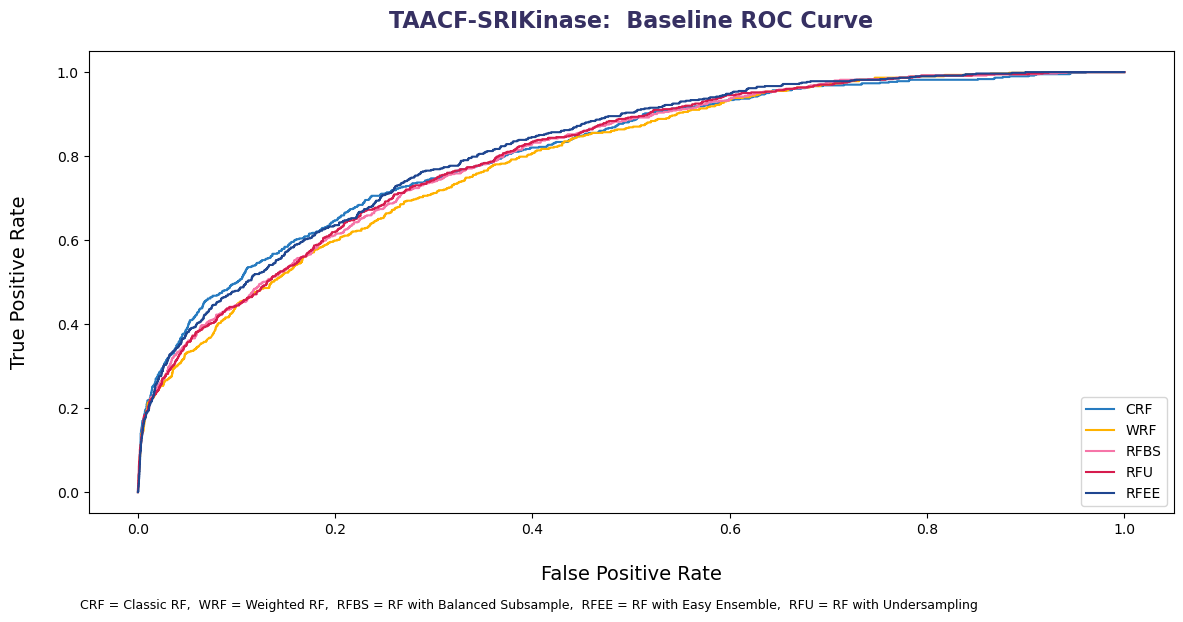

In [92]:
# get auc data and plot
path = f'{data_path}@model/{dir_AUC}/'
df = score.get_auc_data(path, models, xy_AUC, suffix=suffix, baseline=True)

imgfilename = f'{image_path}{filename_img_auc_baseline}{suffix}'
title = f'{dataset_TAACF}-{dataset_SRI}:  Baseline ROC Curve'
score.plot_auc_curve_comparison(df, title, imgfilename, footnote=footnote_models)

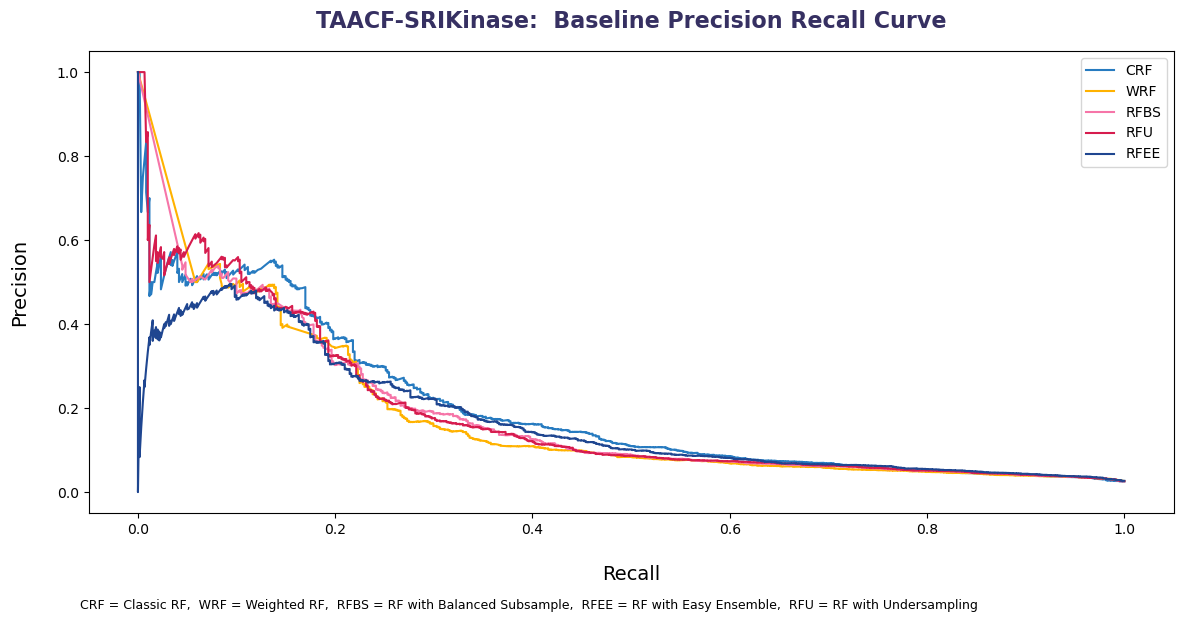

In [93]:
# get precision/recall data and plot
path = f'{data_path}@model/{dir_PrecisionRecall}/'
df = score.get_auc_data(path, models, xy_PrecisionRecall, suffix=suffix, baseline=True)

imgfilename = f'{image_path}{filename_img_pr_baseline}{suffix}'
title = f'{dataset_TAACF}-{dataset_SRI}:  Baseline Precision Recall Curve'
score.plot_recall_curve_comparison(df, title, imgfilename, footnote=footnote_models)

#### 19.  Hyperparameter Optimization

The following scripts were run in parallel on the cluster, once for optimization of the two scores:  balanced accuracy and f1.  Early on during discovery, it was observed that randomized search yielded higher scores than hyperopt, thus the decision to move forward with randomized search instead of hyperopt.  After hyperparameter optimization, the script instantiates a new model with the determined best parameters, trains the model, and saves it for future use (i.e. in the Scoring Model section below)

- optimize-RandomizedSearch-RF-BalancedSubsample.py
- optimize-RandomizedSearch-RF-Classic.py
- optimize-RandomizedSearch-RF-EasyEnsemble.py
- optimize-RandomizedSearch-RF-Undersample.py
- optimize-RandomizedSearch-RF-Weighted.py

#### 20.  Model Evaluation

#####  &nbsp;&nbsp;&nbsp; 20.1  Load splits with smiles/inhibition

In [4]:
# set filenames
filenames_splitdata = score.get_trainsplits_filenames(data_path, suffix, includeCV=True)

# get splits, with smiles and inhibition for visualization
x_train, y_train, x_cv, y_cv, x_test, y_test = score.get_trainsplits(filenames_splitdata)

#remove inhibition and SMILES columns
x_train = x_train.drop(col_NonDescriptors_legacycode, axis=1)
x_cv = x_cv.drop(col_NonDescriptors_legacycode, axis=1)
x_test = x_test.drop(col_NonDescriptors_legacycode, axis=1)

#####  &nbsp;&nbsp;&nbsp; 20.2  Load prior scoring results

In [5]:
GetScores = True
if GetScores:
    dfScores = pd.read_csv(f'{data_path}{filename_model_metrics}{suffix}.csv', index_col=0)
    dfScores = dfScores.sort_values(by=['Group'])
dfScores = dfScores.sort_index()

GetFeatureImporance = False
if GetFeatureImporance:
    dfFeatureImportance = pd.read_csv(f'{data_path}{filename_model_featureimportance}{suffix}.csv', index_col=0)
else:
    dfFeatureImportance = pd.DataFrame()

GetHyperparameters = False
if GetHyperparameters:
    dfHyperparameters = pd.read_csv(f'{data_path}{filename_model_hyperparameter}{suffix}.csv', index_col=0)
else:
    dfHyperparameters = pd.DataFrame()

#####  &nbsp;&nbsp;&nbsp; 20.3  Variables

In [6]:
models = ['crf', 'wrf', 'rfbs', 'rfu', 'rfee']
metrics=['balanced_accuracy', 'f1']
predict = [False, False, False, False, False]
saveFeatureImportance = [True, True, True, True, False]
saveHyperparameters = [True, True, True, True, False]
saveDecisionTree = [True, True, True, True, False]

titles = [f'TAACF-SRIKinase: Classic RF Hyperparameter Optimization'
    , f'TAACF-SRIKinase: Weighted RF Hyperparameter Optimization Performance'
    , f'TAACF-SRIKinase: RF Balanced Subsample Hyperparameter Optimization Performance'
    , f'TAACF-SRIKinase: RF Undersampling Hyperparameter Optimization Performance'
    , f'TAACF-SRIKinase: Easy Ensemble Hyperparameter Optimization Performance']
groups = [f'Classic', f'Weighted', f'Balanced Subsample', f'Undersampling', f'Easy Ensemble']

data_scoring = {'x_cv': x_cv, 
        'y_cv': y_cv,
        'x_test': x_test,
        'y_test': y_test}

cv = 'RSKfold: 10Repeats; 5Splits'

#####  &nbsp;&nbsp;&nbsp; 20.4  Score Models

In [13]:
# train baseline models and make predictions
params_score = {'models': models,
    'metrics': metrics,
    'predict': predict,
    'saveFeatureImportance': saveFeatureImportance,
    'saveHyperparameters': saveHyperparameters,
    'saveDecisionTree': saveDecisionTree,
    'titles': titles, 
    'groups': groups,
    'path_model': model_path,
    'path_data': data_path, 
    'path_image': image_path, 
    'suffix': suffix,
    'data_scoring': data_scoring,
    'dfScores': dfScores,
    'dfFeatureImportance': dfFeatureImportance,
    'dfHyperparameters': dfHyperparameters,
    'predictCvTest': True}

dfScores, dfFeatureImportance, dfHyperparameters = score.score_models(**params_score)
dfScores.to_csv(f'{data_path}{filename_model_metrics}{suffix}_All.csv')
dfFeatureImportance.to_csv(f'{data_path}{filename_model_featureimportance}{suffix}.csv')
dfHyperparameters.to_csv(f'{data_path}{filename_model_hyperparameter}{suffix}.csv')


(process:17228): GLib-GIO-WARNING **: 10:04:38.557: Unexpectedly, UWP app `Microsoft.ScreenSketch_11.2309.16.0_x64__8wekyb3d8bbwe' (AUMId `Microsoft.ScreenSketch_8wekyb3d8bbwe!App') supports 29 extensions but has no verbs

(process:17228): GLib-GIO-WARNING **: 10:04:38.655: Unexpectedly, UWP app `Clipchamp.Clipchamp_2.8.3.0_neutral__yxz26nhyzhsrt' (AUMId `Clipchamp.Clipchamp_yxz26nhyzhsrt!App') supports 41 extensions but has no verbs


(process:33588): GLib-GIO-WARNING **: 10:05:04.616: Unexpectedly, UWP app `Microsoft.ScreenSketch_11.2309.16.0_x64__8wekyb3d8bbwe' (AUMId `Microsoft.ScreenSketch_8wekyb3d8bbwe!App') supports 29 extensions but has no verbs

(process:33588): GLib-GIO-WARNING **: 10:05:04.719: Unexpectedly, UWP app `Clipchamp.Clipchamp_2.8.3.0_neutral__yxz26nhyzhsrt' (AUMId `Clipchamp.Clipchamp_yxz26nhyzhsrt!App') supports 41 extensions but has no verbs


(process:26944): GLib-GIO-WARNING **: 10:05:33.283: Unexpectedly, UWP app `Microsoft.ScreenSketch_11.2309.16.0_x64__8we

In [9]:
# remove baseline results after confirming hyperparameter optimization metrics are better than baseline metrics
dfScores_trained = dfScores[~(dfScores.index.str.contains(" Baseline| CV"))].sort_index()
dfScores_trained_styled = dfScores_trained.copy()
#dfScores_trained_styled.sort_values(by=['Group'])

imgfilename = f'{image_path}{filename_img_metrics}{suffix}'
title = f'{dataset}:  RF Performance'
hide = ['Group']
score.get_ClassifierScores(dfScores_trained_styled, title, imgfilename, hide=hide, top=3)

c:\Users\frogi\anaconda3\envs\tb\lib\site-packages\dataframe_image\_pandas_accessor.py:69: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  html = '<div>' + obj.render() + '</div>'


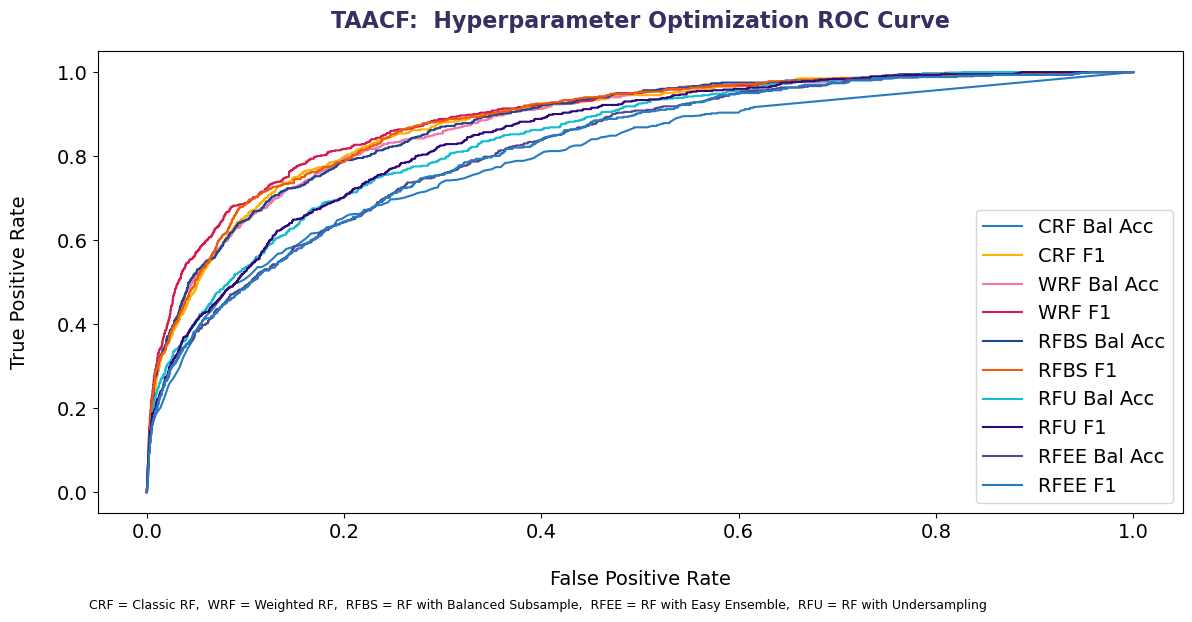

In [18]:
# get auc data and plot
path = f'{data_path}@model/{dir_AUC}/'
metrics=['balanced_accuracy', 'f1']
df = score.get_auc_data(path, models, xy_AUC, suffix=suffix, baseline=False, metrics=metrics)

imgfilename = f'{image_path}{filename_img_auc}{suffix}'
title = f'{dataset}:  Hyperparameter Optimization ROC Curve'
score.plot_auc_curve_comparison(df, title, imgfilename, footnote=footnote_models)

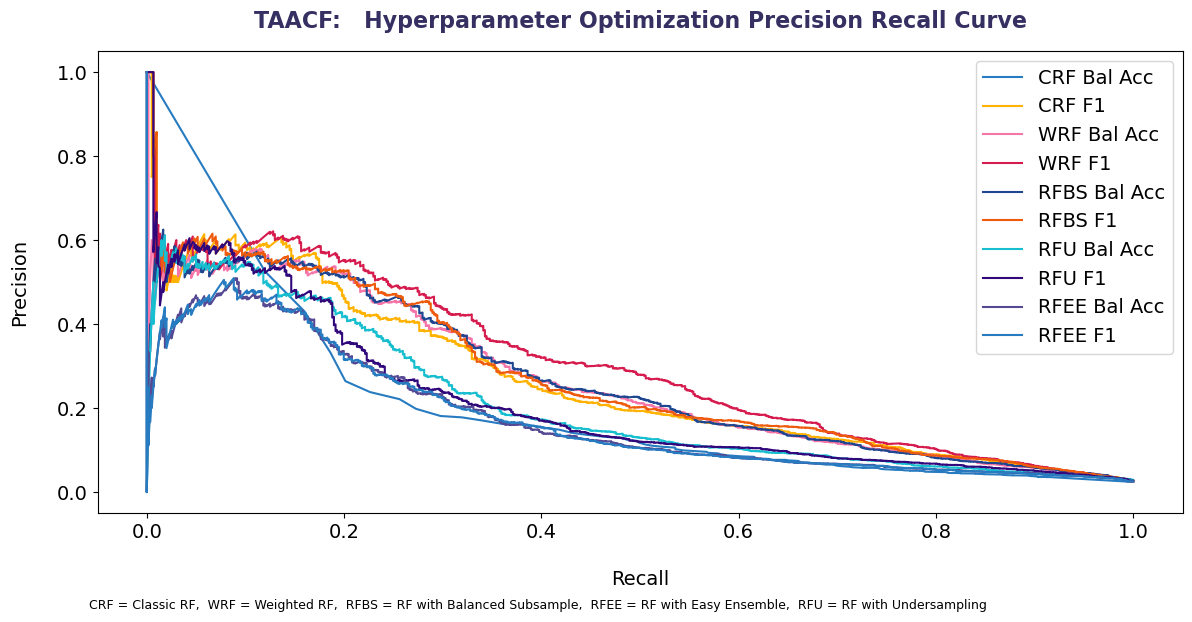

In [19]:
# get precision/recall data and plot
path = f'{data_path}@model/{dir_PrecisionRecall}/'
metrics=['balanced_accuracy', 'f1']
df = score.get_auc_data(path, models, xy_PrecisionRecall, suffix=suffix, baseline=False, metrics=metrics)

imgfilename = f'{image_path}{filename_img_pr}{suffix}'
title = f'{dataset}:   Hyperparameter Optimization Precision Recall Curve'
score.plot_recall_curve_comparison(df, title, imgfilename, footnote=footnote_models)

In [24]:
dfFeatureImportance

CRF balanced_accuracy      CRF f1  RFBS balanced_accuracy     RFBS f1   \
1              SlogP_VSA1        logS                    logS        logS   
2              PEOE_VSA+6  PEOE_VSA+6               logP(o/w)  PEOE_VSA+6   
3                    logS       h_pKb                   h_emd       h_emd   
4                 vsa_acc    SMR_VSA4                 vsa_acc       h_pKb   
5                   h_pKb  SlogP_VSA1              PEOE_VSA+6     vsa_acc   
6                   h_emd       h_emd                  h_logS    SMR_VSA4   
7                   a_aro     h_emd_C                   h_pKb  SlogP_VSA1   
8              SlogP_VSA2   logP(o/w)                 vsa_pol   logP(o/w)   
9                 vsa_pol     vsa_acc                SMR_VSA4     h_emd_C   
10                h_emd_C       a_aro           PEOE_VSA_PPOS   h_log_pbo   

   RFU balanced_accuracy      RFU f1  WRF balanced_accuracy         WRF f1   
1                    logS        logS                   logS           logS  
2               logP(o/w)  PEOE_VSA+6              logP(o/w)     PEOE_VSA+6  
3              PEOE_VSA+6       h_pKb                  h_emd      logP(o/w)  
4                   h_emd       h_emd                vsa_acc       SMR_VSA4  
5                  h_logS     vsa_acc                vsa_pol        vsa_pol  
6                 vsa_pol    SMR_VSA4             PEOE_VSA+6          h_emd  
7                 vsa_acc     h_emd_C                 h_logS          h_pKb  
8                   SlogP   logP(o/w)                  SlogP        vsa_acc  
9                 h_emd_C  SlogP_VSA1                h_emd_C  PEOE_VSA_PPOS  
10               SMR_VSA1     vsa_pol                  h_pKb       SMR_VSA1

In [25]:
dfHyperparameters

CRF balanced_accuracy                       CRF f1   \
method                           RandomSearchCV               RandomSearchCV   
scoring                       balanced_accuracy                           f1   
cv                  RSKfold: 10Repeats; 5Splits  RSKfold: 10Repeats; 5Splits   
n_iter                                       20                           20   
score                                  0.534081                     0.117119   
n_estimators                                425                          425   
min_samples_split                            22                            6   
min_samples_leaf                            275                           75   
max_features                               None                         None   
max_depth                                   450                           25   
criterion                               entropy                      entropy   
class_weight                                n/a                          n/a   
bootstrap                                 False                         True   
max_terminal_nodes                          n/a                          n/a   
max_samples                                 n/a                          n/a   

                        RFBS balanced_accuracy                      RFBS f1   \
method                           RandomSearchCV               RandomSearchCV   
scoring                       balanced_accuracy                           f1   
cv                  RSKfold: 10Repeats; 5Splits  RSKfold: 10Repeats; 5Splits   
n_iter                                       20                           20   
score                                  0.756829                     0.304081   
n_estimators                                400                          425   
min_samples_split                            23                            6   
min_samples_leaf                            175                           75   
max_features                               sqrt                         None   
max_depth                                   250                           25   
criterion                               entropy                      entropy   
class_weight                 balanced_subsample           balanced_subsample   
bootstrap                                 False                         True   
max_terminal_nodes                          n/a                          n/a   
max_samples                                 n/a                          n/a   

                         RFU balanced_accuracy                       RFU f1   \
method                           RandomSearchCV               RandomSearchCV   
scoring                       balanced_accuracy                           f1   
cv                  RSKfold: 10Repeats; 5Splits  RSKfold: 10Repeats; 5Splits   
n_iter                                       30                           30   
score                                  0.737732                     0.157277   
n_estimators                                375                          225   
min_samples_split                             4                           17   
min_samples_leaf                             50                          100   
max_features                               log2                         None   
max_depth                                   211                          447   
criterion                               entropy                      entropy   
class_weight                 balanced_subsample           balanced_subsample   
bootstrap                                  True                         True   
max_terminal_nodes                          n/a                          n/a   
max_samples                                 n/a                          n/a   

                         WRF balanced_accuracy                       WRF f1   
method                           RandomSearchCV               RandomSearchCV  
scoring                 

#### 21.  Top 2 Models

##### &nbsp;&nbsp;&nbsp;21.1 Load splits with smiles/inhibition

In [7]:
# set filenames
filenames_splitdata = score.get_trainsplits_filenames(data_path, suffix, includeCV=True)

# get splits, with smiles and inhibition for visualization
x_train, y_train, x_cv, y_cv, x_test, y_test = score.get_trainsplits(filenames_splitdata)

# used later to change data point colors in graph based on inhibition values
# and to store PCA/tSNE results for the molecules in the training dataset
x_train_SMILES = x_train[col_NonDescriptors_legacycode].copy()
x_cv_SMILES = x_cv[col_NonDescriptors_legacycode].copy()
x_test_SMILES = x_test[col_NonDescriptors_legacycode].copy()

#remove inhibition and SMILES columns
x_train = x_train.drop(col_NonDescriptors_legacycode, axis=1)
x_cv = x_cv.drop(col_NonDescriptors_legacycode, axis=1)
x_test = x_test.drop(col_NonDescriptors_legacycode, axis=1)

##### &nbsp;&nbsp;&nbsp;21.2 Load prior scoring results

In [8]:
GetScores = True
if GetScores:
    dfScores = pd.read_csv(f'{data_path}{filename_model_metrics}{suffix}_All.csv', index_col=0)
    dfScores = dfScores.sort_values(by=['Group'])
dfScores = dfScores[~(dfScores.index.str.contains(" Baseline | CV"))].sort_index()

GetFeatureImporance = True
if GetFeatureImporance:
    dfFeatureImportance = pd.read_csv(f'{data_path}{filename_model_featureimportance}{suffix}.csv', index_col=0)

GetHyperparameters = True
if GetHyperparameters:
    dfHyperparameters = pd.read_csv(f'{data_path}{filename_model_hyperparameter}{suffix}.csv', index_col=0)

# keep the top 2 models 
models_topModel = ['WRF', 'CRF']
models_topModelMetrics = ['WRF F1', 'CRF F1']

##### &nbsp;&nbsp;&nbsp;21.3 Model Metrics

In [13]:
dfScores_top = dfScores[dfScores.index.str.contains('|'.join(models_topModelMetrics))].sort_index()
dfScores_top_styled = dfScores_top.copy()
#dfScores_trained_styled.sort_values(by=['Group'])

imgfilename = f'{image_path}{filename_img_metrics}{suffix}'
title = f'{dataset}:  Hyperparameter Opitmization - Model Selection'
hide = ['Group']
score.get_ClassifierScores(dfScores_top_styled, title, imgfilename, hide=hide, top=2)

c:\Users\frogi\anaconda3\envs\tb\lib\site-packages\dataframe_image\_pandas_accessor.py:69: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  html = '<div>' + obj.render() + '</div>'


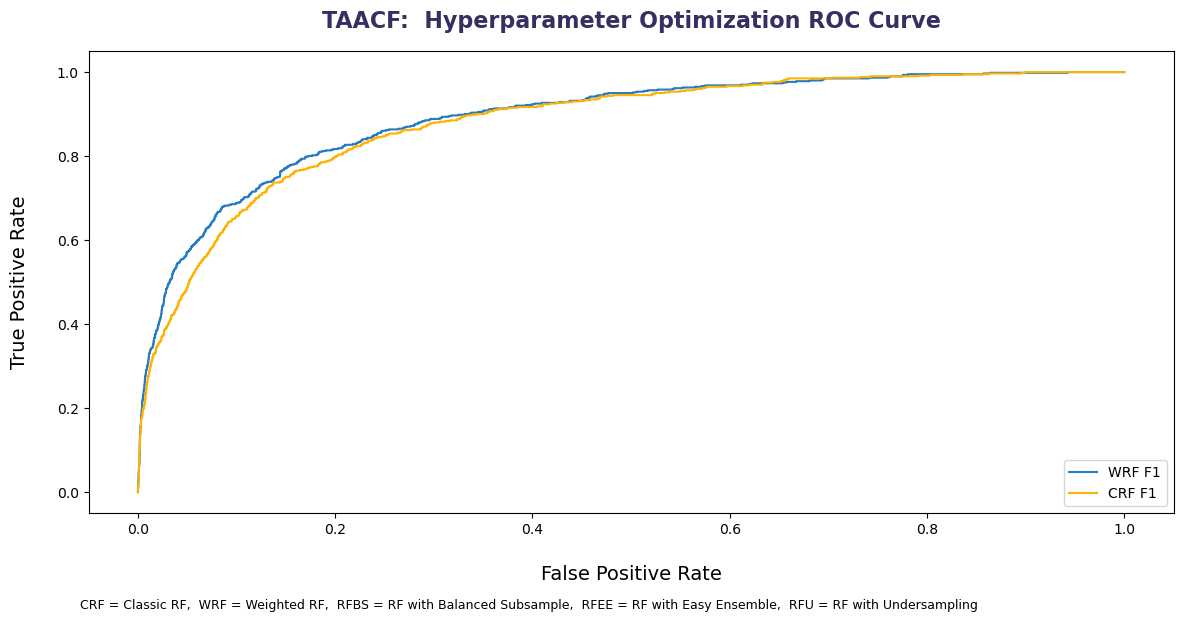

In [15]:
# get auc data and plot
path = f'{data_path}@model/{dir_AUC}/'
metrics=['f1']
df = score.get_auc_data(path, models_topModel, xy_AUC, suffix=suffix, baseline=False, metrics=metrics)

imgfilename = f'{image_path}{filename_img_auc_topmodels}{suffix}'
title = f'{dataset}:  Hyperparameter Optimization ROC Curve'
score.plot_auc_curve_comparison(df, title, imgfilename, footnote=footnote_models)

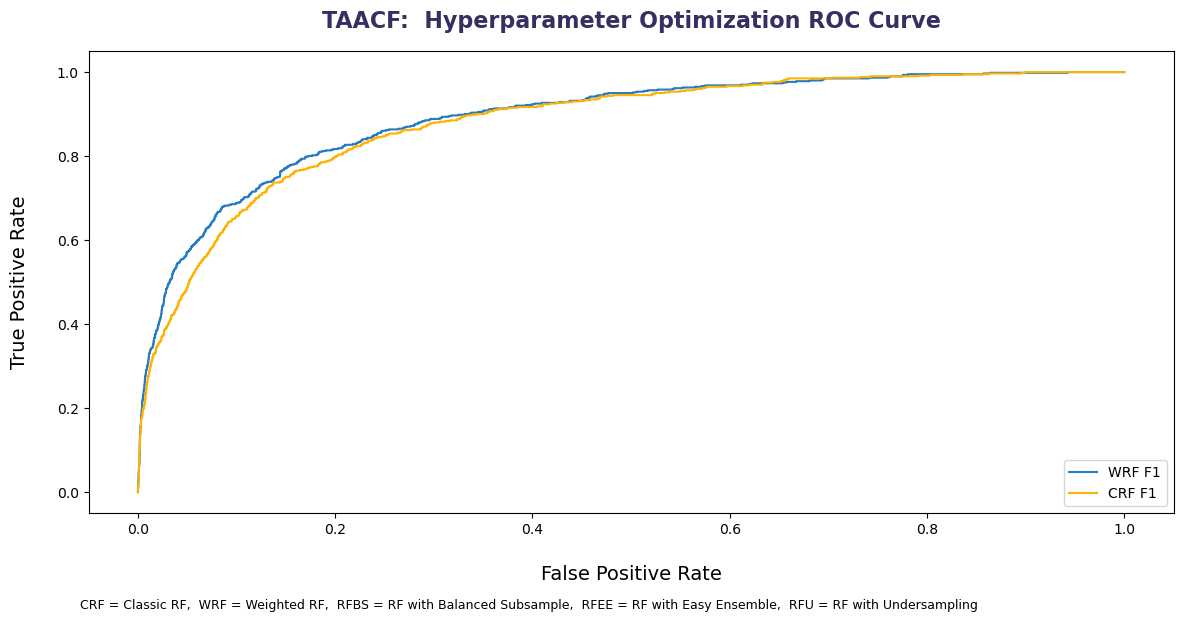

In [16]:
# get auc data and plot
path = f'{data_path}@model/{dir_AUC}/'
metrics=['f1']
df = score.get_auc_data(path, models_topModel, xy_AUC, suffix=suffix, baseline=False, metrics=metrics)

imgfilename = f'{image_path}model{filename_img_auc_topmodels}{suffix}'
title = f'{dataset}:  Hyperparameter Optimization ROC Curve'
score.plot_auc_curve_comparison(df, title, imgfilename, footnote=footnote_models)

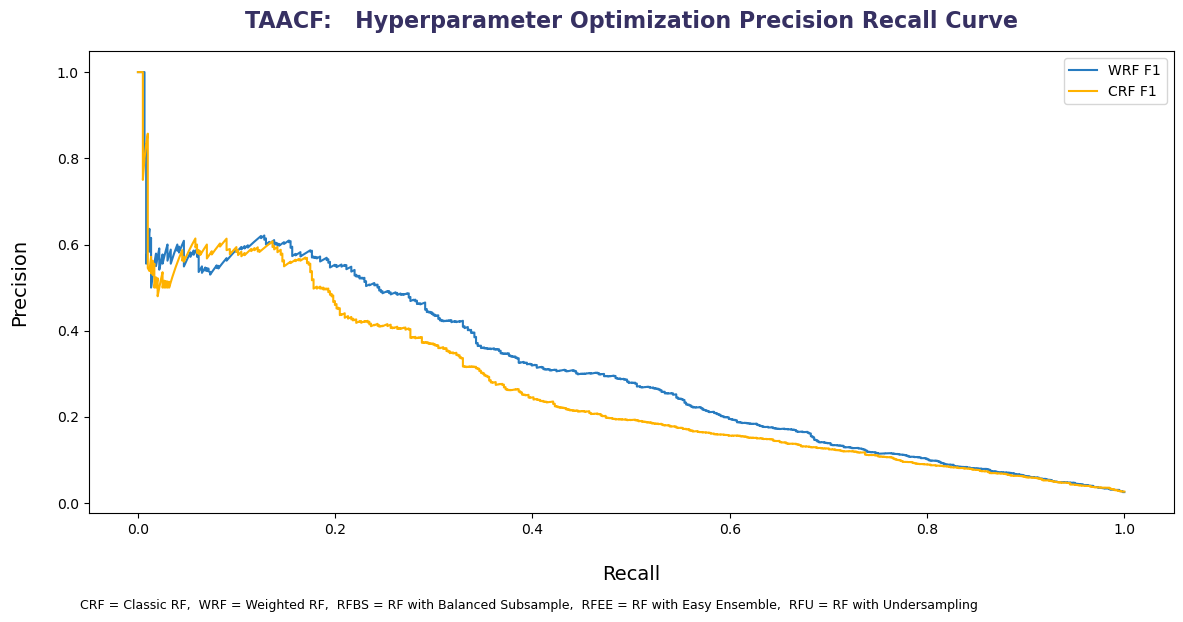

In [17]:
# get precision/recall data and plot
path = f'{data_path}@model/{dir_PrecisionRecall}/'
metrics=['f1']
df = score.get_auc_data(path, models_topModel, xy_PrecisionRecall, suffix=suffix, baseline=False, metrics=metrics)

imgfilename = f'{image_path}model{filename_img_pr_topmodels}{suffix}'
title = f'{dataset}:   Hyperparameter Optimization Precision Recall Curve'
score.plot_recall_curve_comparison(df, title, imgfilename, footnote=footnote_models)

##### &nbsp;&nbsp;&nbsp;21.4 Feature Importance & Model Parameters

In [32]:
cols_topmodels = ['WRF f1 ', 'CRF f1 ']
cols_renamed = {'WRF f1 ': 'Weighted RF - F1', 'CRF f1 ': 'Classic RF - F1'}
top = '2'

In [33]:
dfFeatureImportance_TopModels = dfFeatureImportance[cols_topmodels]
dfFeatureImportance_TopModels.rename(columns=cols_renamed, inplace=True)

imgfilename = f'{image_path}{filename_img_featureimportance_top}{suffix}'
title = f'{dataset}:  Hyperparameter Optimization<br>Feature Importance<br>Top {top} Models'
score.plot_StyledDataFrame(dfFeatureImportance_TopModels, title, imgfilename)

c:\Users\frogi\anaconda3\envs\tb\lib\site-packages\dataframe_image\_pandas_accessor.py:69: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  html = '<div>' + obj.render() + '</div>'


In [34]:
dfHyperparameters_TopModels = dfHyperparameters[cols_topmodels]
dfHyperparameters_TopModels.rename(columns=cols_renamed, inplace=True)


imgfilename = f'{image_path}{filename_img_hyperparameter_top}{suffix}'
title = f'{dataset}:  Hyperparameter Optimization<br>Best Parameters ~ Top {top} Models'
score.plot_StyledDataFrame(dfHyperparameters_TopModels, title, imgfilename)


c:\Users\frogi\anaconda3\envs\tb\lib\site-packages\dataframe_image\_pandas_accessor.py:69: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  html = '<div>' + obj.render() + '</div>'


##### &nbsp;&nbsp;&nbsp;21.5 tSNE Prediction Representation

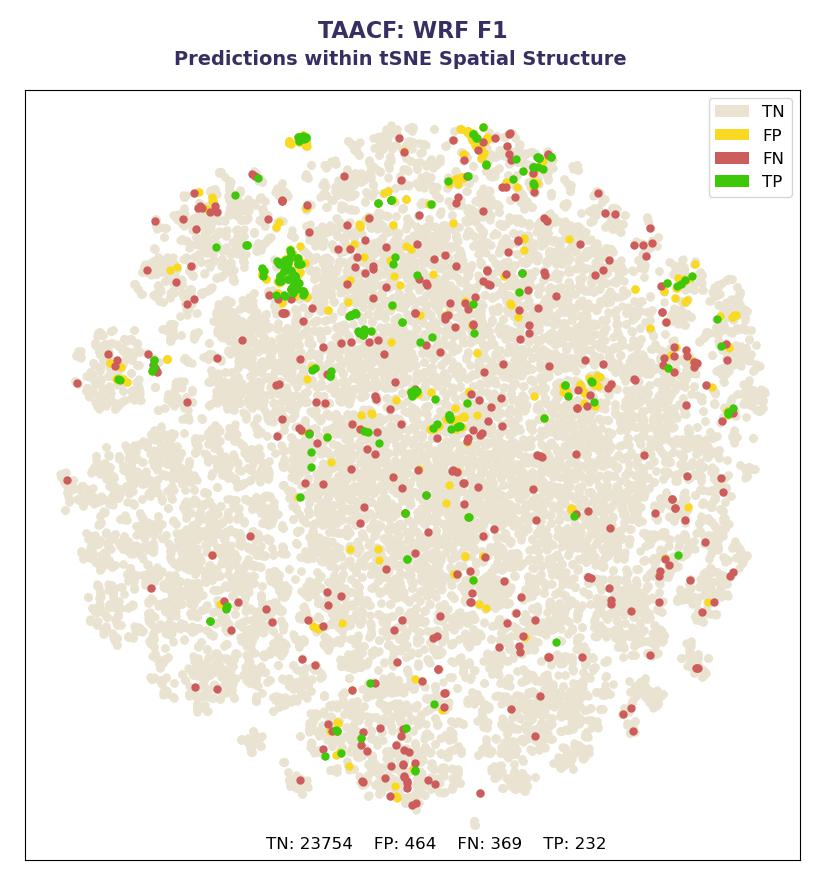

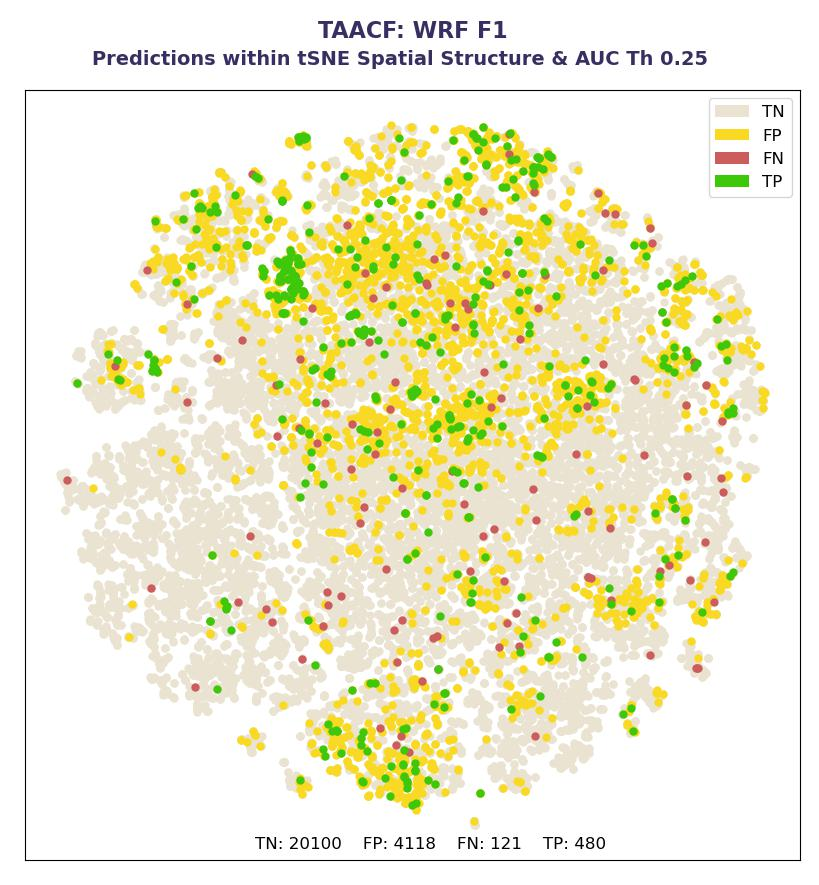

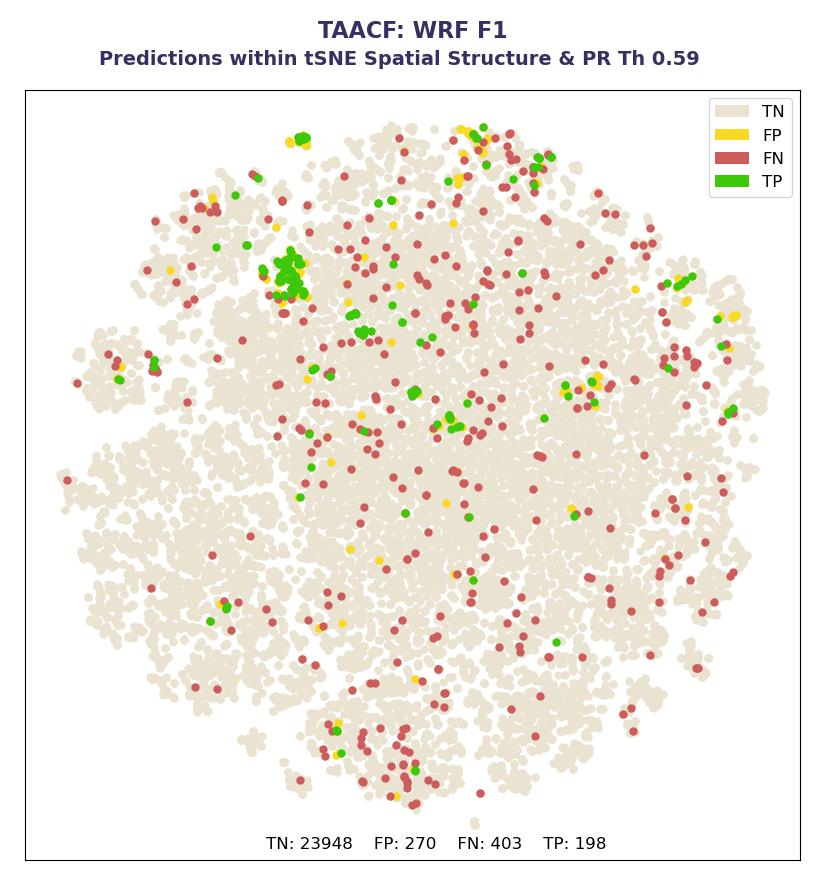

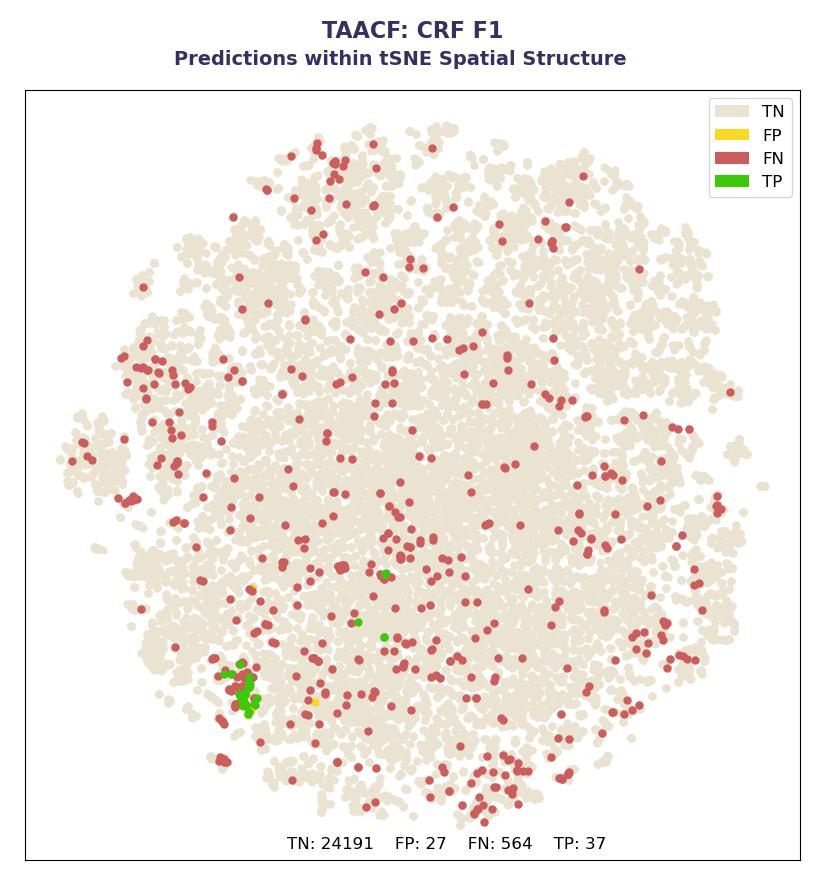

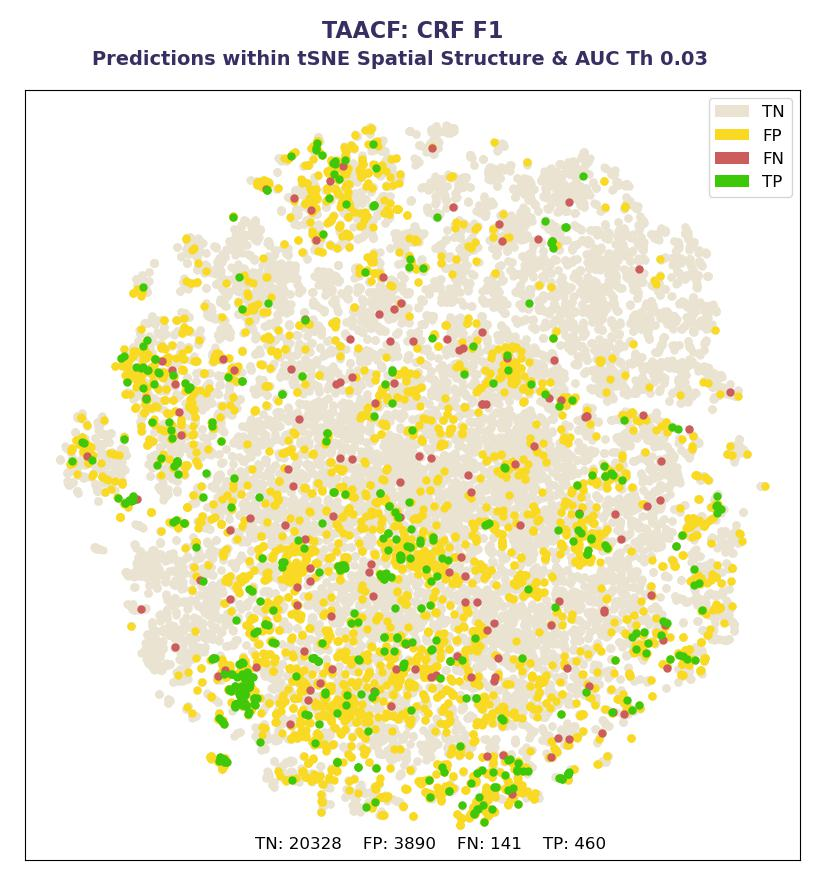

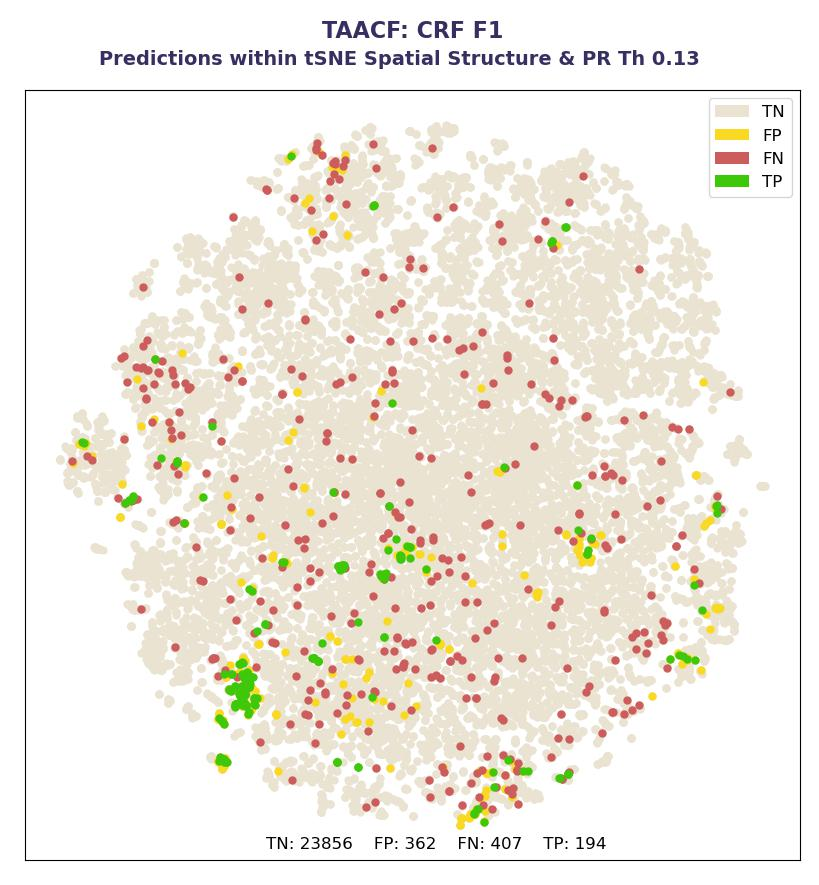

In [15]:
models_top = ['wrf', 'crf']
models_metric = ['f1', 'f1']
models_th_auc = {'wrf': 0.2533, 'crf': 0.0338}
models_th_pr = {'wrf': 0.5907, 'crf': 0.1262}
pc_num = 50
perplexity = 10
getSavedModel = True
subtitle = 'Predictions within tSNE Spatial Structure'


params = {'dataset': dataset,
        'suffix': suffix,
        'models': models_top,
        'metrics': models_metric,
        'thresholds_auc': models_th_auc,
        'thresholds_pr': models_th_pr,
        'x': x_test,
        'x_smiles': x_test_SMILES,
        'y': y_test, 
        'pc_num': pc_num,
        'data_path' : data_path,
        'model_path' : model_path,
        'image_path' : image_path,
        'perplexity': perplexity,       
        'removeticks': True,
        'subtitle': subtitle,
        'getSavedModel': getSavedModel}

score.plot_model_predictions_tsne(**params)

##### &nbsp;&nbsp;&nbsp;21.6 UMAP Prediction Representation

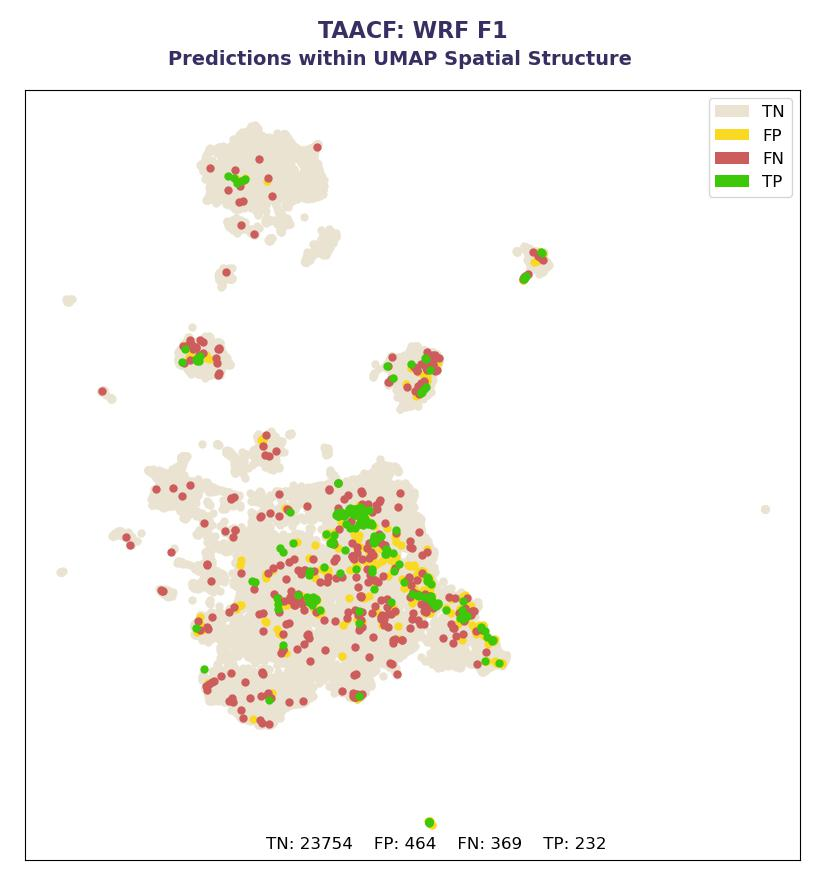

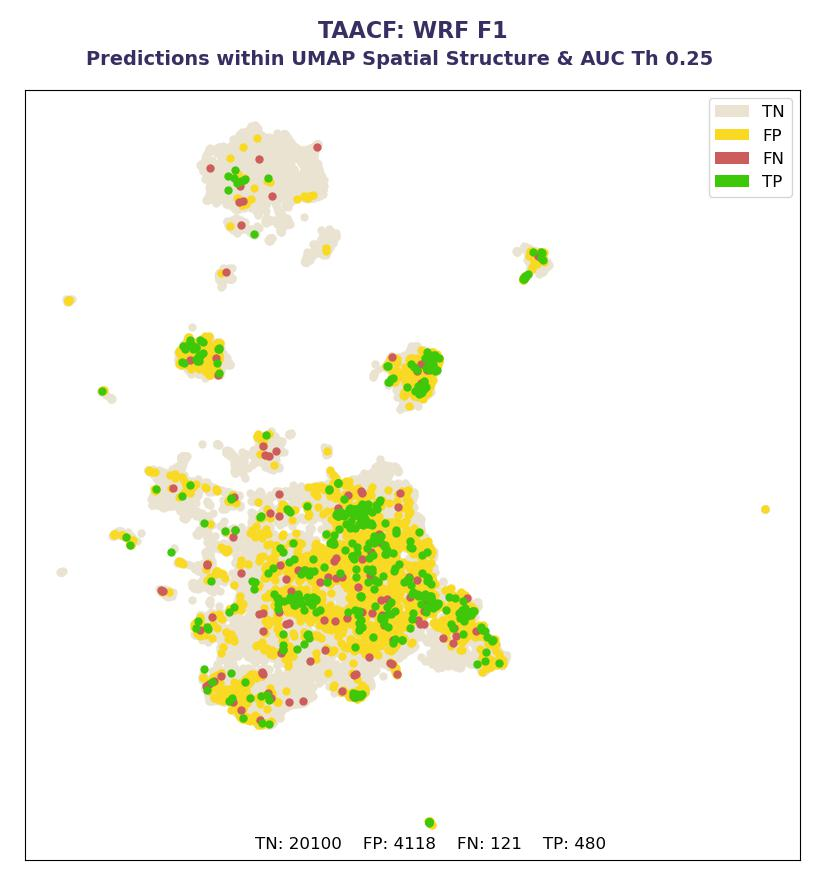

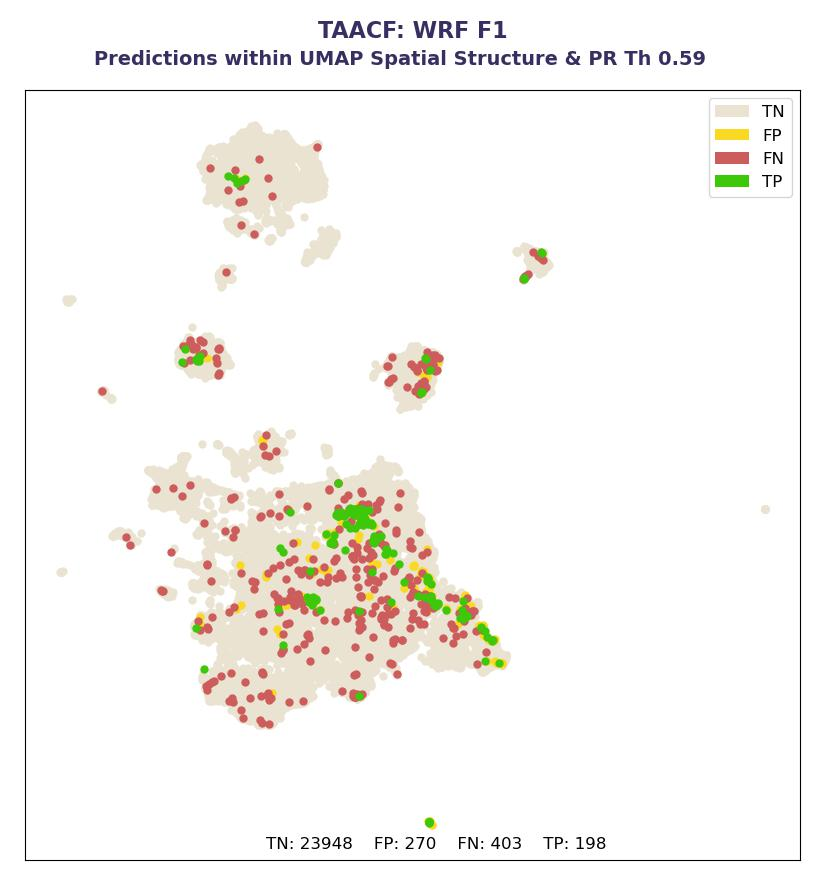

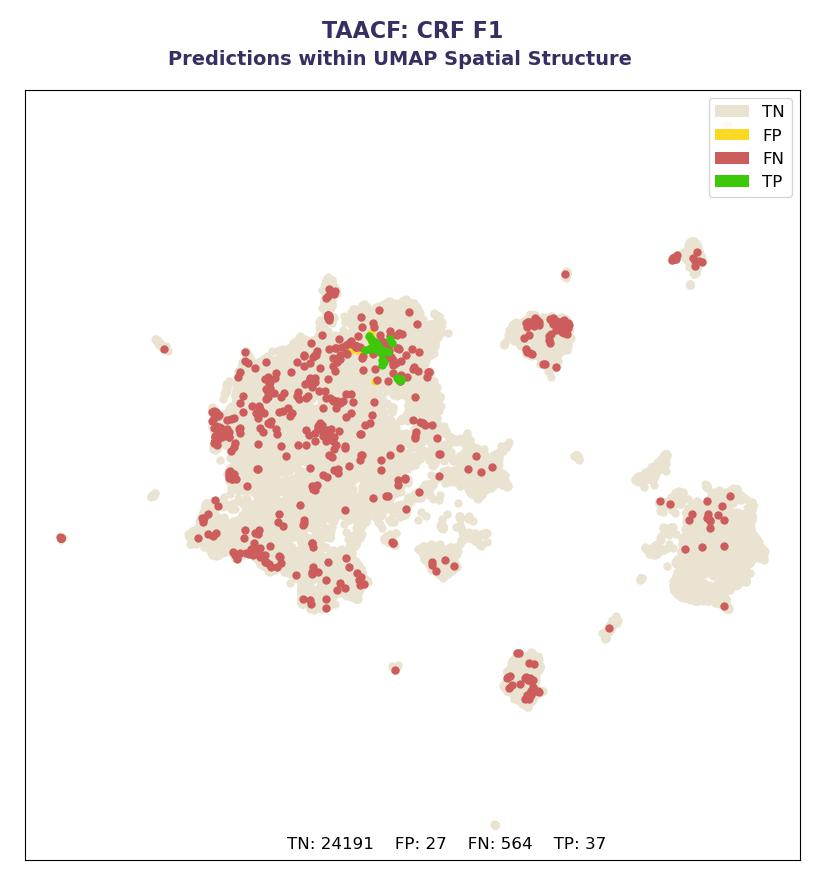

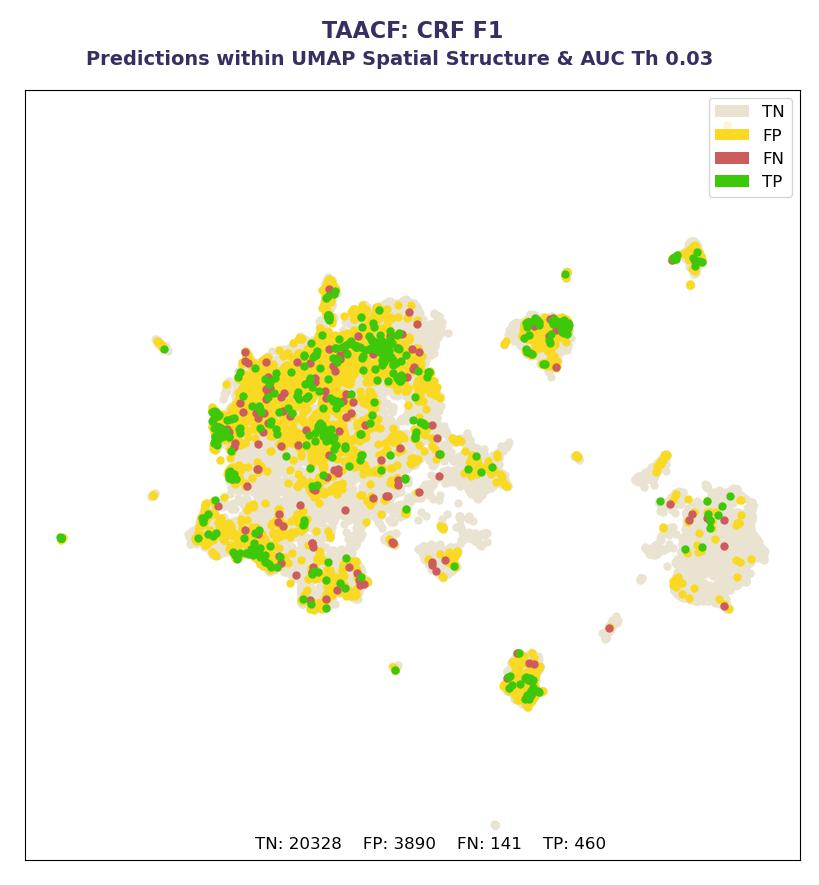

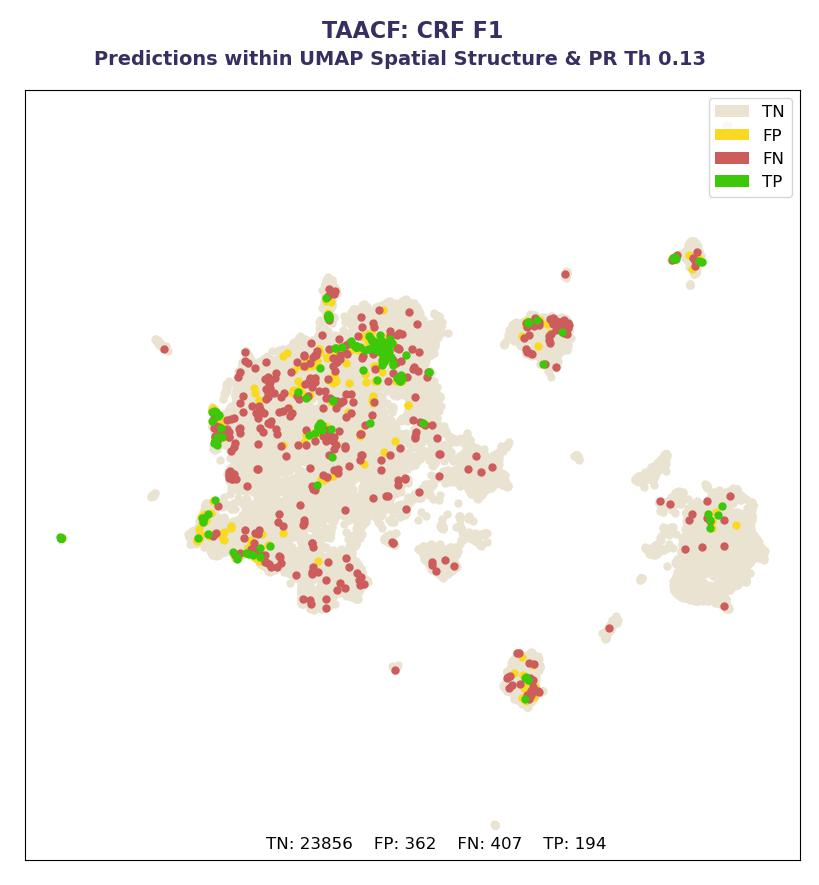

In [12]:
models_top = ['wrf', 'crf']
models_metric = ['f1', 'f1']
models_th_auc = {'wrf': 0.2533, 'crf': 0.0338}
models_th_pr = {'wrf': 0.5907, 'crf': 0.1262}
n_neighbors = 15
min_dist = 0.25
getSavedModel = True
subtitle = 'Predictions within UMAP Spatial Structure'


params = {'dataset': dataset,
        'suffix': suffix,
        'models': models_top,
        'metrics': models_metric,
        'thresholds_auc': models_th_auc,
        'thresholds_pr': models_th_pr,
        'x': x_test,
        'x_smiles': x_test_SMILES,
        'y': y_test, 
        'data_path' : data_path,
        'model_path' : model_path,
        'image_path' : image_path,
        'n_neighbors': n_neighbors,
        'min_dist': min_dist,       
        'subtitle': subtitle,
        'getSavedModel': getSavedModel}

score.plot_model_predictions_umap(**params)

#### 22.  Model Uncertainty & Variance

##### &nbsp;&nbsp;&nbsp; 22.1 Uncertainty Methods

<p style="margin-left: 25px">
    The uncertainty in the model’s prediction for the top-performing models were quantified by generating confidence intervals (CI) using three methods:  train/test splits, bootstrap, and normal approximation.  The following scripts were run in parallel on the cluster, once for each top performing model.  See MethodsEmployed.txt for details and references.  

       - quantify-bootstrap.py
       - quantify-traintestsplit.py
</p>

##### &nbsp;&nbsp;&nbsp; 22.2 Load splits with smiles/inhibition

In [4]:
# set filenames
filenames_splitdata = score.get_trainsplits_filenames(data_path, suffix, includeCV=True)

# get splits, with smiles and inhibition for visualization
x_train, y_train, x_cv, y_cv, x_test, y_test = score.get_trainsplits(filenames_splitdata)

#remove inhibition and SMILES columns
x_train = x_train.drop(col_NonDescriptors_legacycode, axis=1)
x_cv = x_cv.drop(col_NonDescriptors_legacycode, axis=1)
x_test = x_test.drop(col_NonDescriptors_legacycode, axis=1)

# concatenate train and cv 
dataset_list = [x_train, x_cv]  
x_train_cv = pd.concat(dataset_list)
y_train_cv = np.concatenate((y_train, y_cv))

##### &nbsp;&nbsp;&nbsp; 22.3 Variables

In [14]:
models = ['wrf', 'crf']
sequences = [1, 2]
metrics = ['f1', 'f1']
graph_trainsplits_yrange = [4, 1.25]
graph_bootstrap_range = [[0.355, 0.377], [0.110, 0.155]]
graph_bootstrap_bins = [5, 5]
graph_bootstrap_ymax_mean = [300, 300]
graph_bootstrap_ymax_ci = [75, 75]
graph_bootstrap632_range = [[0.35, 0.655], [0.110, 0.171]]
graph_bootstrap632_bins = [5, 5]
graph_bootstrap632_ymax_mean = [300, 300]
graph_bootstrap632_ymax_ci = [75, 75]
graph_normapprox_range = [[0.35, 0.367], [0.106, 0.116]]
graph_ci_range = [[0.32, 0.40], [0.08, 0.155]]
graph_ci_redline_height = [3, 3]

##### &nbsp;&nbsp;&nbsp; 22.4 Model Uncertainty



Model:  WRF
-----------------------------------------------------------------------------------------------


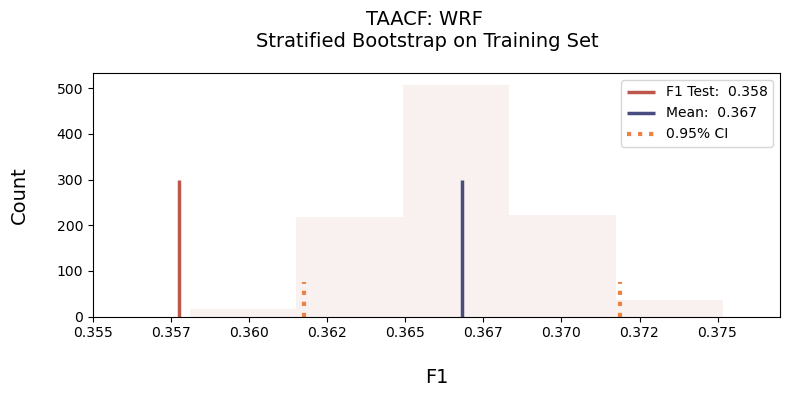

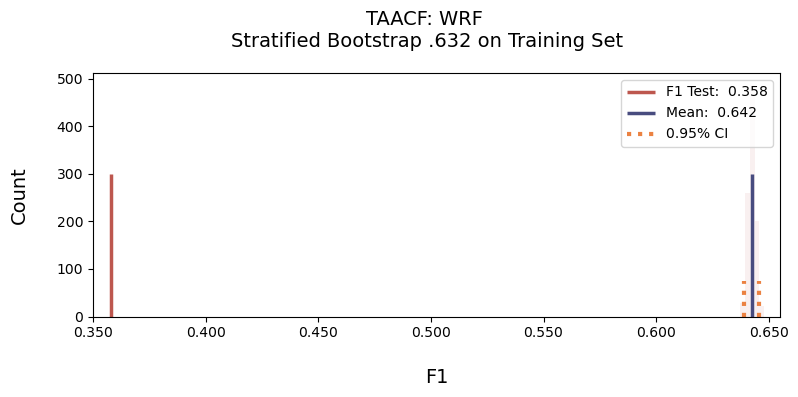

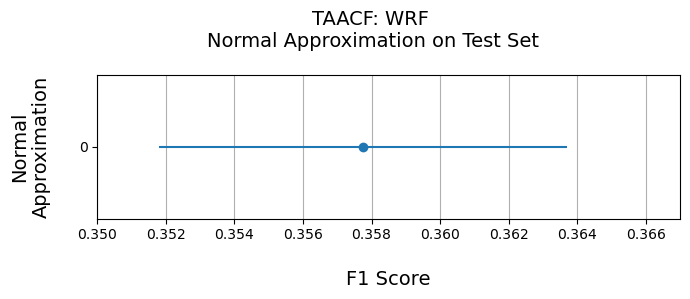

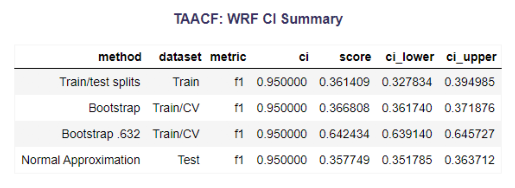

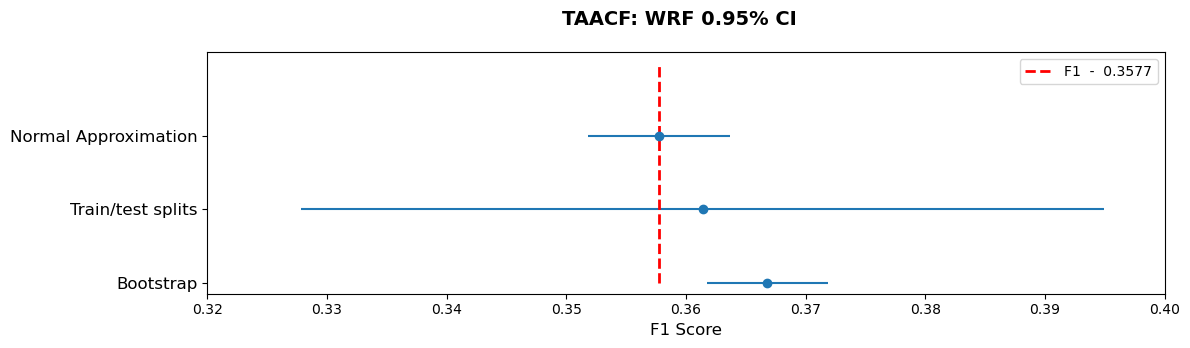

<Figure size 640x480 with 0 Axes>

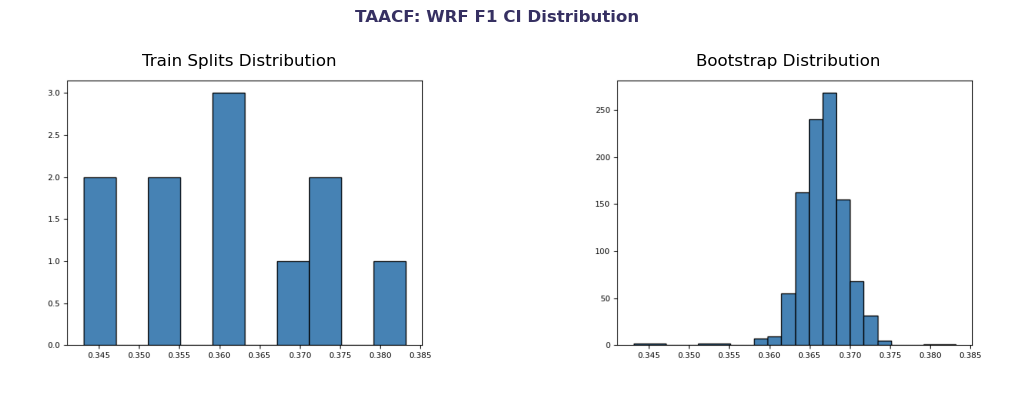

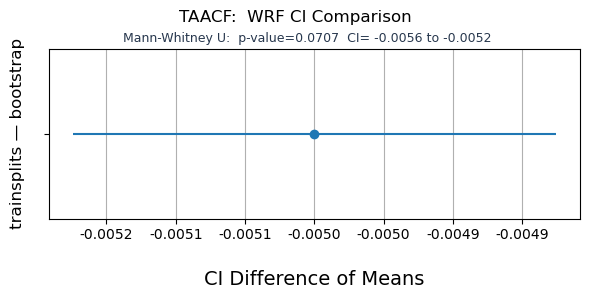

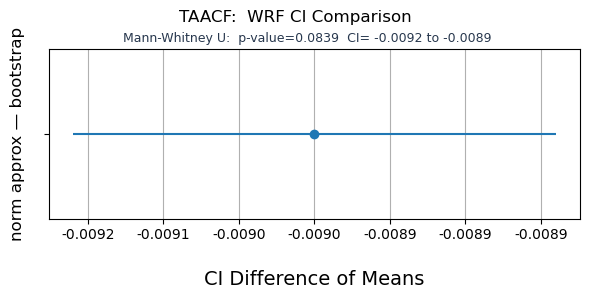

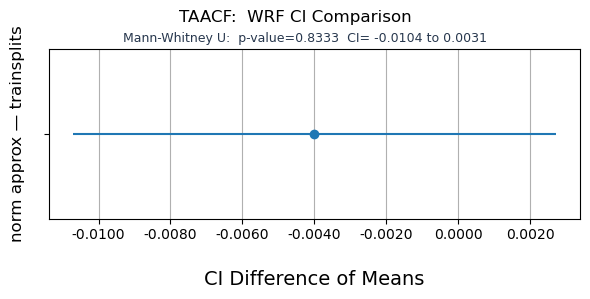



Model:  CRF
-----------------------------------------------------------------------------------------------


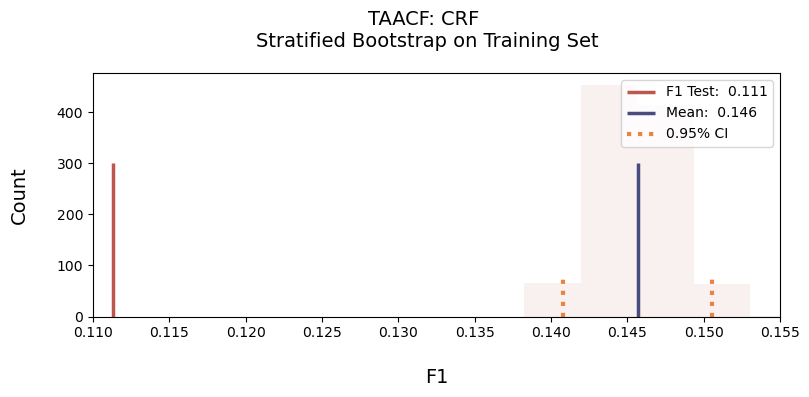

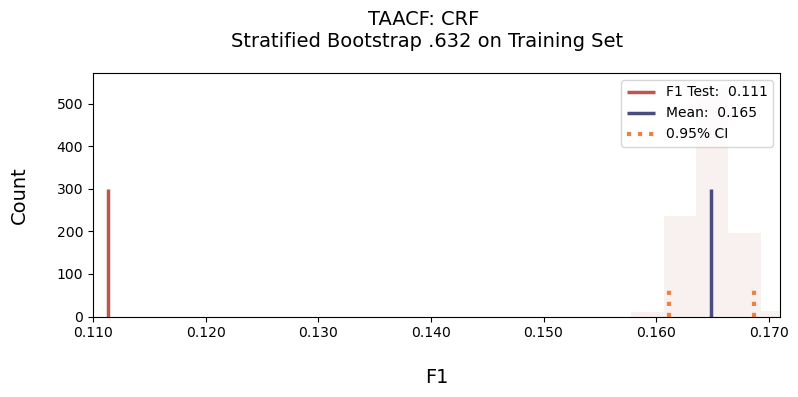

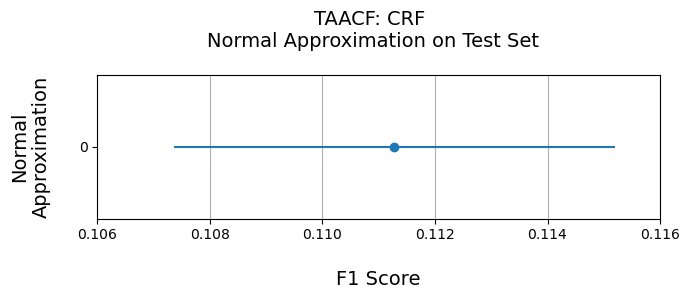

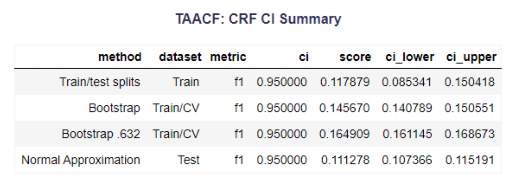

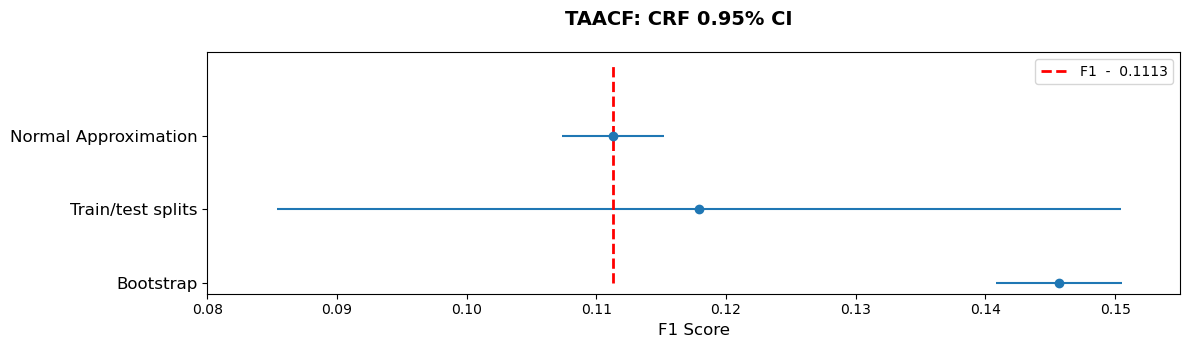

<Figure size 640x480 with 0 Axes>

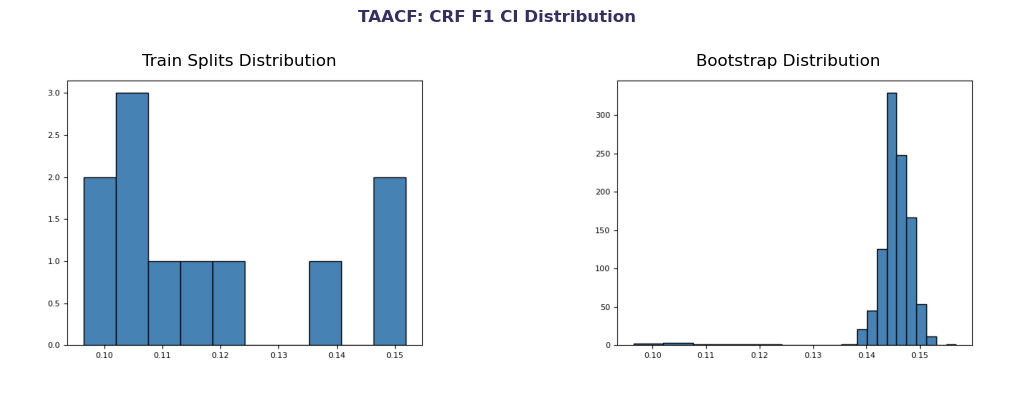

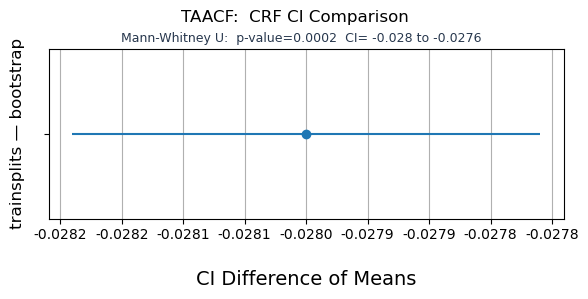

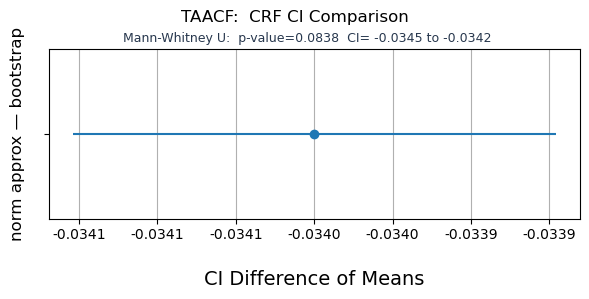

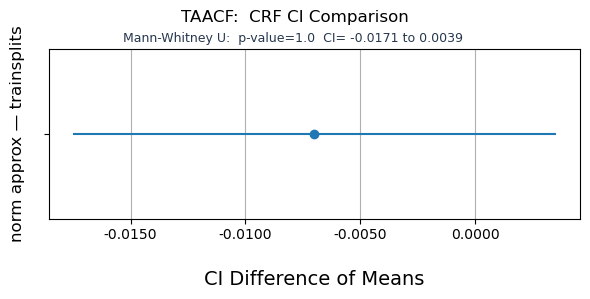



Model Comparison:
-----------------------------------------------------------------------------------------------


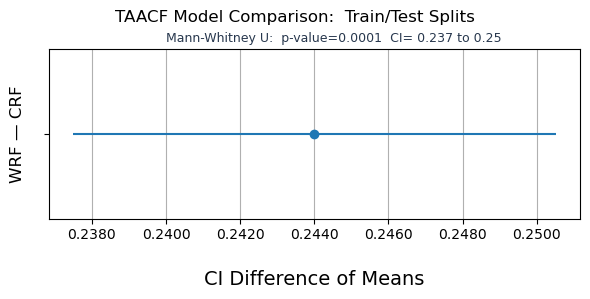

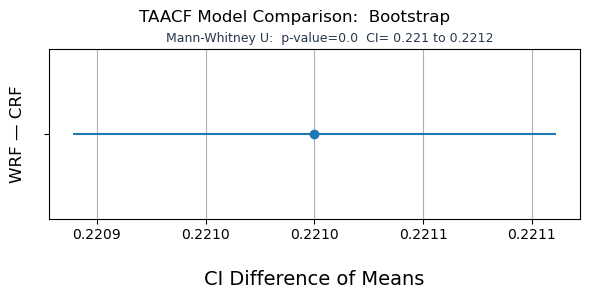

In [15]:
# instantiate optimized models, score and compare
params_ci = {'dataset': dataset,
    'suffix': suffix,
    'models': models,
    'sequences': sequences,
    'metrics': metrics,
    'ci': CI,
    'data_path': data_path,
    'model_path': model_path, 
    'image_path': image_path,
    'x': x_test,
    'y_truth': y_test,
    'graph_trainsplits_yrange': graph_trainsplits_yrange,
    'graph_bootstrap_range': graph_bootstrap_range,
    'graph_bootstrap632_range': graph_bootstrap632_range,
    'graph_bootstrap_bins': graph_bootstrap_bins,
    'graph_bootstrap632_bins': graph_bootstrap632_bins,
    'graph_bootstrap_ymax_mean': graph_bootstrap_ymax_mean,
    'graph_bootstrap632_ymax_mean': graph_bootstrap632_ymax_mean,
    'graph_bootstrap_ymax_ci': graph_bootstrap_ymax_ci,
    'graph_bootstrap632_ymax_ci': graph_bootstrap632_ymax_ci,
    'graph_normapprox_range': graph_normapprox_range,
    'graph_normapprox_range': graph_normapprox_range,
    'graph_ci_range': graph_ci_range,
    'graph_ci_redline_height': graph_ci_redline_height}

quantify.get_model_uncertainty(**params_ci)

#### 23.  Score MLSMR with TAACF

##### &nbsp;&nbsp;&nbsp;23.1 Load TAACF data

In [22]:
# Dataset was split into 3 separate files:  
# Descriptors_{suffix_MLSMR}.csv:  processed unscaled MLSMR data. used for scoring.
# y{suffix_MLSMR}.csv:  y labels for data (activity = 1 or 0).  used for tSNE and UMAP, training, scoring.
# Molecules{suffix_MLSMR}.csv:  contains SMILES and Inhibition rates.  used for tSNE and UMAP, training, scoring.

score_features = pd.read_csv(f'{data_path}{filename_descriptors_unscaled}{suffix_MLSMR}.csv', index_col=0)
score_y = pd.read_csv(f'{data_path}y{suffix_MLSMR}.csv', index_col=0)
score_y_true = np.array(score_y['Activity'].tolist())
score_molecules = pd.read_csv(f"{data_path}Molecules{suffix_MLSMR}.csv", index_col=0)
score_SMILES = score_molecules[col_NonDescriptors_legacycode].copy()

# add smiles, label, and inhibition 
# this is used to map out the predictions (TP, FP, TN, FN) with tSNE/UMAP
score_mol_y_features = pd.concat([score_molecules[col_NonDescriptors_legacycode], score_y, score_features], axis = 1)

C:\Users\frogi\AppData\Local\Temp\ipykernel_21780\4167492133.py:9: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  score_molecules = pd.read_csv(f"{data_path}Molecules{suffix_MLSMR}.csv", index_col=0)


##### &nbsp;&nbsp;&nbsp;23.2 Scale data

In [26]:
#get data the model was trained on, to retrieve columns 
# set filenames, get splits, and remove inhibition and SMILES columns
filenames_splitdata = score.get_trainsplits_filenames(data_path, suffix_TAACF, includeCV=False)
x_train, y_train, x_test, y_test = score.get_trainsplits(filenames_splitdata)
x_train = x_train.drop(col_NonDescriptors_legacycode, axis=1)

# get the StandardScaler used when training the model and use it to scale new data
file_scaler = f'{data_path}{filename_scaler}{suffix_TAACF}.sclr'
score_features_scaled = score.scale_data(score_features, x_train, file_scaler)

##### &nbsp;&nbsp;&nbsp;23.3 Load prior scoring results

In [31]:
GetScores = False
if GetScores:
    dfScores = pd.read_csv(f'{data_path}{filename_model_metrics}{suffix}_scoring{suffix_MLSMR}.csv', index_col=0)
dfScores = dfScores.sort_index()

##### &nbsp;&nbsp;&nbsp;23.4 Variables

In [42]:
dataset_scored = 'MLSMR'
models = ['wrf', 'crf']
metrics=['f1', 'f1']
footnote_models = 'WRF = Weighted RF, CRF = Classic RF'
predict = [True, True]
saveFeatureImportance = [False, False]
saveHyperparameters = [False, False]
saveDecisionTree = [False, False]

titles = [f'{dataset}: Weighted RF Scoring {dataset_scored} Performance'
    , f'{dataset}: Classic RF Scoring {dataset_scored} Performance']
groups = [f'Weighted', f'Classic']

data_scoring = {'x_test': score_features_scaled,
        'y_test': score_y_true}
scoring_suffix = f'_scoring{suffix_MLSMR}'

##### &nbsp;&nbsp;&nbsp;23.5 Score Models

In [35]:
# instantiate optimized models, score and compare
params_score = {'models': models,
    'metrics': metrics,
    'predict': predict,
    'saveFeatureImportance': saveFeatureImportance,
    'saveHyperparameters': saveHyperparameters,
    'saveDecisionTree': saveDecisionTree,
    'titles': titles, 
    'groups': groups,
    'path_model': model_path,
    'path_data': data_path, 
    'path_image': image_path, 
    'suffix': suffix,
    'data_scoring': data_scoring,
    'dfScores': dfScores,
    'scoring_suffix': scoring_suffix}

dfScores, dfFeatureImportance, dfHyperparameters = score.score_models(**params_score)
dfScores.to_csv(f'{data_path}{filename_model_metrics}{suffix}_scoring{suffix_MLSMR}.csv')

##### &nbsp;&nbsp;&nbsp;23.6 Model Performance

In [41]:
dfScores_styled = dfScores.copy()
#dfScores_trained_styled.sort_values(by=['Group'])

imgfilename = f'{image_path}{filename_img_metrics}{suffix}{scoring_suffix}'
title = f'{dataset}:  Scoring {dataset_scored} Performance'
hide = ['Group']
score.get_ClassifierScores(dfScores_styled, title, imgfilename, hide=hide, top=2)

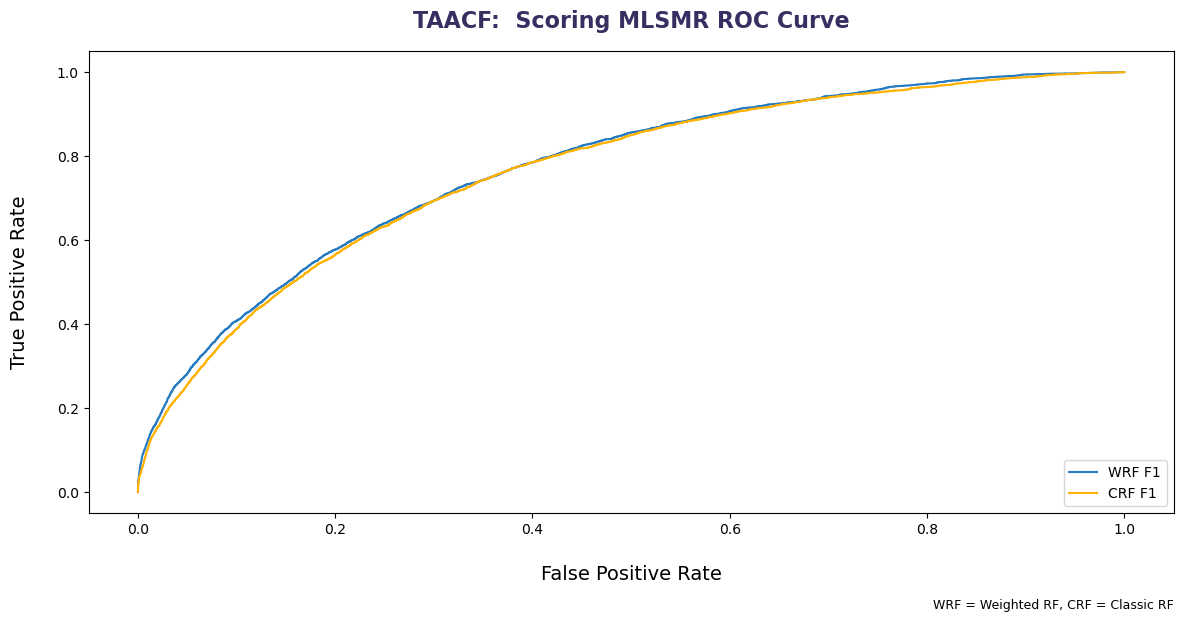

In [44]:
# get auc data and plot
path = f'{data_path}@model/{dir_AUC}/'
metrics=['f1']
df = score.get_auc_data(path, models, xy_AUC, suffix=suffix, baseline=False, metrics=metrics, scoring_suffix=scoring_suffix)

imgfilename = f'{image_path}model{filename_img_auc}{suffix}{scoring_suffix}'
title = f'{dataset}:  Scoring {dataset_scored} ROC Curve'
score.plot_auc_curve_comparison(df, title, imgfilename, footnote=footnote_models, xy=(1, -0.2))

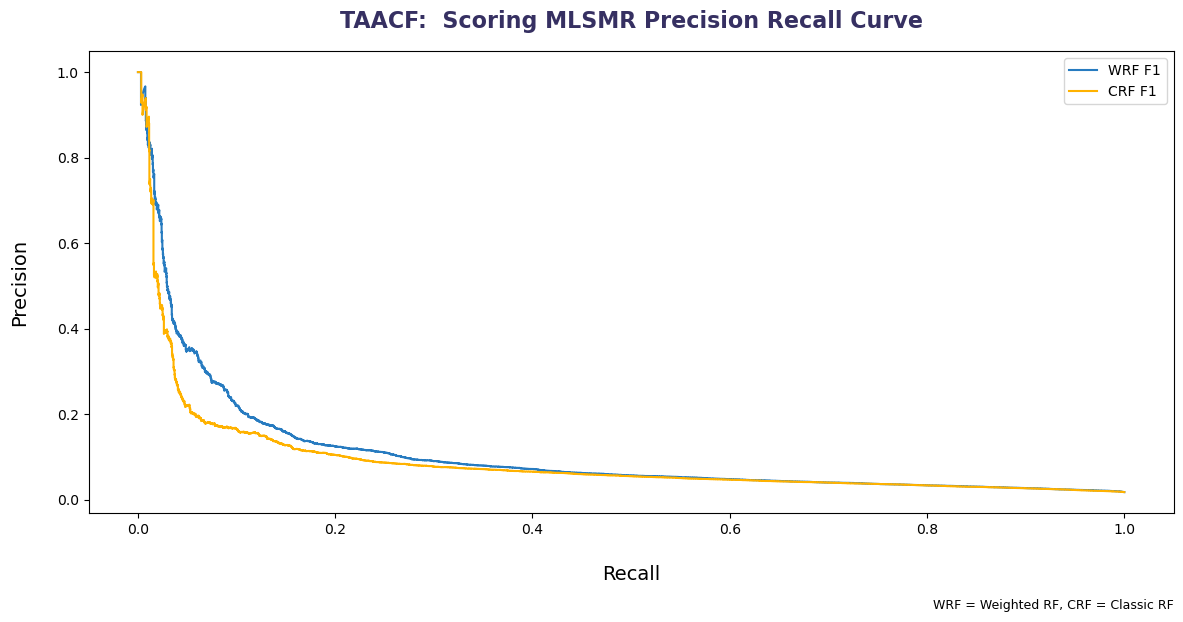

In [46]:
# get precision/recall data and plot
path = f'{data_path}@model/{dir_PrecisionRecall}/'
metrics=['f1']
df = score.get_auc_data(path, models, xy_PrecisionRecall, suffix=suffix, baseline=False, metrics=metrics, scoring_suffix=scoring_suffix)

imgfilename = f'{image_path}model{filename_img_pr}{suffix}{scoring_suffix}'
title = f'{dataset}:  Scoring {dataset_scored} Precision Recall Curve'
score.plot_recall_curve_comparison(df, title, imgfilename, footnote=footnote_models, xy=(1, -0.2))